# 코로나 신규 확진자수 추이

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import matplotlib
from numpy import inf
from sklearn.cluster import KMeans

matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

In [2]:
covid.to_csv('Covid-19_with_day.csv', encoding="euc-kr")

NameError: name 'covid' is not defined

In [ ]:
covid = pd.read_csv("Covid-19.csv")
covid.head()

In [ ]:
covid.Date = '2020-' + covid.Date
covid['Date'] = pd.to_datetime(covid.Date, format='%Y-%m-%d')
covid['WEEK_NUM'] = covid['Date'].dt.weekofyear

weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
covid['WEEKDAY'] = covid.Date.dt.dayofweek.apply(lambda x : weekdays.get(x))

covid.head()

In [ ]:
def graph_corona_time_plot(covid):
    ax = covid['Total '].plot(figsize=(16, 6))
    ax.axvline(x=20, color='r', linewidth=2, linestyle='--')
    plt.text(x=7, 
             y=covid['Total '].max()*0.9, 
             s='코로나 타격 \n{}주차 {}요일'.format(covid['WEEK_NUM'][20], covid['WEEKDAY'][20]), 
             fontsize=14)
    plt.title("코로나 신규확진자수 (한국)", fontsize=14)
    plt.show()

In [ ]:
graph_corona_time_plot(covid)

# 업종 별 EDA

# __ __ __ __ __ __ __ __ __ __ __ __ __ __ __

In [3]:
offline = pd.read_csv("CARD_SPENDING_RESIDENT_KOR.csv")
offline.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,AVG_AMT,YEAR,MONTH,DAY,YEAR_MONTH
0,20190201,대구 중구,동인동,숙박,F,25,11,595,54.090909,2019,2,1,201902
1,20190201,대구 중구,동인동,숙박,F,50,5,243,48.600000,2019,2,1,201902
2,20190201,대구 중구,동인동,숙박,F,55,5,27,5.400000,2019,2,1,201902
3,20190201,대구 중구,동인동,숙박,M,20,11,243,22.090909,2019,2,1,201902
4,20190201,대구 중구,동인동,숙박,M,25,11,433,39.363636,2019,2,1,201902


In [4]:
# 요일 계산 (dt.dayofweek를 통해 해당 날짜의 요일을 반환할 수 있음.)
weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
offline['STD_DD'] = pd.to_datetime(offline.STD_DD, format='%Y%m%d')
offline['WEEKDAY'] = offline.STD_DD.dt.dayofweek.apply(lambda x : '_'.join([str(x),weekdays.get(x)]))
offline.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,AVG_AMT,YEAR,MONTH,DAY,YEAR_MONTH,WEEKDAY
0,2019-02-01,대구 중구,동인동,숙박,F,25,11,595,54.090909,2019,2,1,201902,4_금
1,2019-02-01,대구 중구,동인동,숙박,F,50,5,243,48.600000,2019,2,1,201902,4_금
2,2019-02-01,대구 중구,동인동,숙박,F,55,5,27,5.400000,2019,2,1,201902,4_금
3,2019-02-01,대구 중구,동인동,숙박,M,20,11,243,22.090909,2019,2,1,201902,4_금
4,2019-02-01,대구 중구,동인동,숙박,M,25,11,433,39.363636,2019,2,1,201902,4_금


In [5]:
# 주차 계산 (마찬가지로 dt.weekofyear을 통해 해당 날짜의 주차를 알 수 있음.)
offline['WEEK_NUM'] = offline['STD_DD'].dt.weekofyear
offline.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,AVG_AMT,YEAR,MONTH,DAY,YEAR_MONTH,WEEKDAY,WEEK_NUM
0,2019-02-01,대구 중구,동인동,숙박,F,25,11,595,54.090909,2019,2,1,201902,4_금,5
1,2019-02-01,대구 중구,동인동,숙박,F,50,5,243,48.600000,2019,2,1,201902,4_금,5
2,2019-02-01,대구 중구,동인동,숙박,F,55,5,27,5.400000,2019,2,1,201902,4_금,5
3,2019-02-01,대구 중구,동인동,숙박,M,20,11,243,22.090909,2019,2,1,201902,4_금,5
4,2019-02-01,대구 중구,동인동,숙박,M,25,11,433,39.363636,2019,2,1,201902,4_금,5


In [6]:
print(set(offline['MCT_CAT_CD']))

{'자동차판매', '직물', '연료판매', '신변잡화', '가구', '사무통신', '보건위생', '광학제품', '의복', '자동차 정비', '유통업', '레저용품', '레저업소', '숙박', '주방용구', '수리서비스', '전기', '음료식품', '가전', '문화취미', '요식업소', '의료기관', '서적문구'}


# 특정 업종 선택 (사무통신)

## 1. 전년 대비 동월 비교

In [7]:
def graph_by_year_month_offline(category_name):
    # 카테고리에 속하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # YEAR, MONTH로 묶고 AMT, CNT 합 구하기
    category_df = category_df.groupby(['YEAR', 'MONTH'])[['USE_AMT', 'USE_CNT']].sum().reset_index()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    sns.barplot(x=category_df['MONTH'], y=category_df['USE_CNT'], hue='YEAR', data=category_df, ax=axes[0])
    sns.barplot(x=category_df['MONTH'], y=category_df['USE_AMT'], hue='YEAR', data=category_df, ax=axes[1])
    axes[0].set_title(category_name + "의 월별 소비횟수")
    axes[1].set_title(category_name + "의 월별 소비금액")

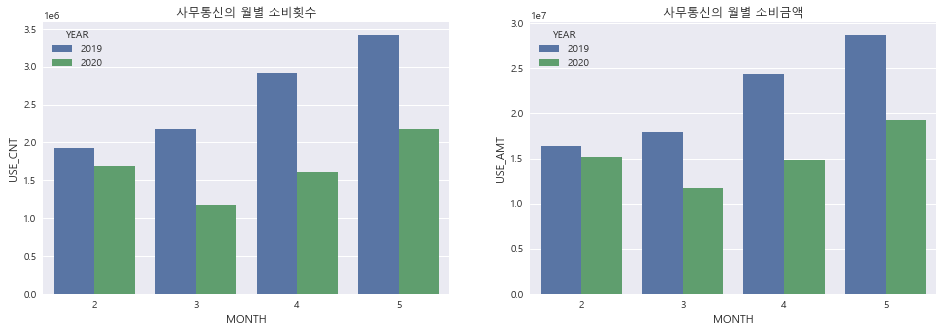

In [8]:
graph_by_year_month_offline("사무통신")

## 2. 연령 별로 시간에 따른 변화율 관찰

### (1) 19년과 20년의 월별 비중 변화

In [9]:
def graph_by_year_month_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # YEAR_MONTH별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR_MONTH', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    # graph 화면을 2개의 row와 1개의 column으로 분할하기.
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
    # 막대 그래프를 그릴 때, x축과 y축을 설정하고, hue는 분할 기준, ax는 그림의 위치
    sns.barplot(x='YEAR_MONTH', y='USE_CNT', hue=hue_column, data=category_df, ax=axes[0])
    sns.barplot(x='YEAR_MONTH', y='USE_AMT', hue=hue_column, data=category_df, ax=axes[1])
    # 그림에 제목을 달자.
    axes[0].set_title(category_name + "의 {}별 소비횟수".format(hue_column))
    axes[1].set_title(category_name + "의 {}별 소비금액".format(hue_column))
    # 범례를 추가하되, 위치까지 설정.
    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    # 수직라인을 그리되, x축의 위치 설정, 색깔, 선의 굵기, 선 스타일 설정.
    axes[0].axvline(x=3.5, color='r', linewidth=2, linestyle='--')
    axes[1].axvline(x=3.5, color='r', linewidth=2, linestyle='--')

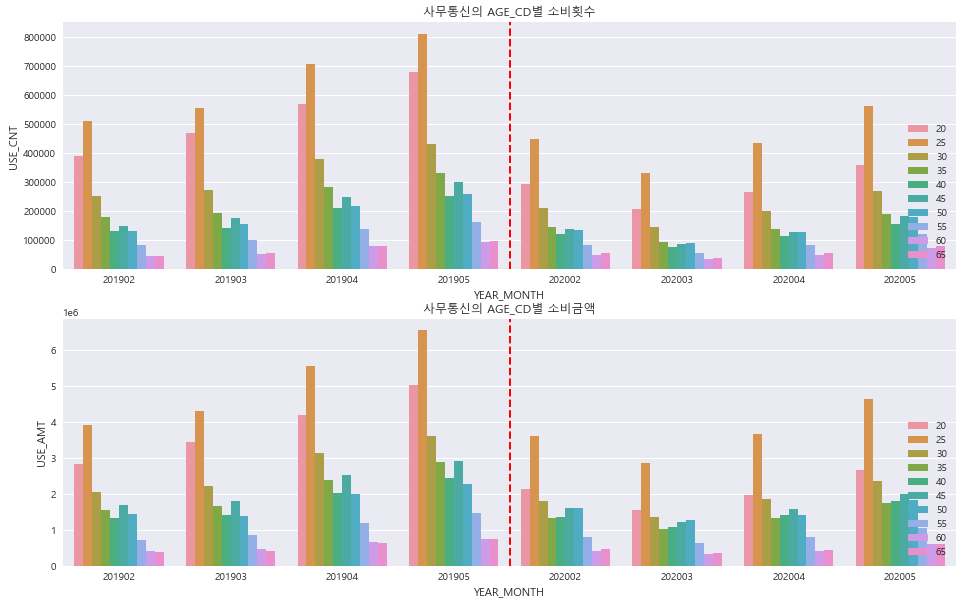

In [10]:
graph_by_year_month_offline("사무통신", "AGE_CD")

### (2) 19년과 20년의 주별 비중 변화

In [11]:
def graph_by_month_number_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 주차별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEK_NUM', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    df_2019 = category_df.query('YEAR==2019')
    df_2020 = category_df.query('YEAR==2020')
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 20))
    sns.barplot(x='WEEK_NUM', y='USE_CNT', hue=hue_column, data=df_2019, ax=axes[0])
    sns.barplot(x='WEEK_NUM', y='USE_CNT', hue=hue_column, data=df_2020, ax=axes[1])
    sns.barplot(x='WEEK_NUM', y='USE_AMT', hue=hue_column, data=df_2019, ax=axes[2])
    sns.barplot(x='WEEK_NUM', y='USE_AMT', hue=hue_column, data=df_2020, ax=axes[3])
    
    aggregate_columns = ['USE_CNT', 'USE_AMT']
    years = [2019, 2020]
    for i in [0, 1, 2, 3]:
        axes[i].set_title(category_name + "{}년의 {}별 {}".format(years[i%2], hue_column, aggregate_columns[i//2]))
        axes[i].legend(loc='lower right')
        axes[i].set_ylim([0, category_df[aggregate_columns[i//2]].max()*1.1])
        axes[i].axvline(x=2.5, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=6.5, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=14.5, color='g', linewidth=2, linestyle='--')
        axes[i].text(x=2.5, y=category_df[aggregate_columns[i//2]].max()*0.9, s="　코로나 확산기(8~11주)")
        axes[i].text(x=14.5, y=category_df[aggregate_columns[i//2]].max()*0.9, s="　재난지원금 지급주")

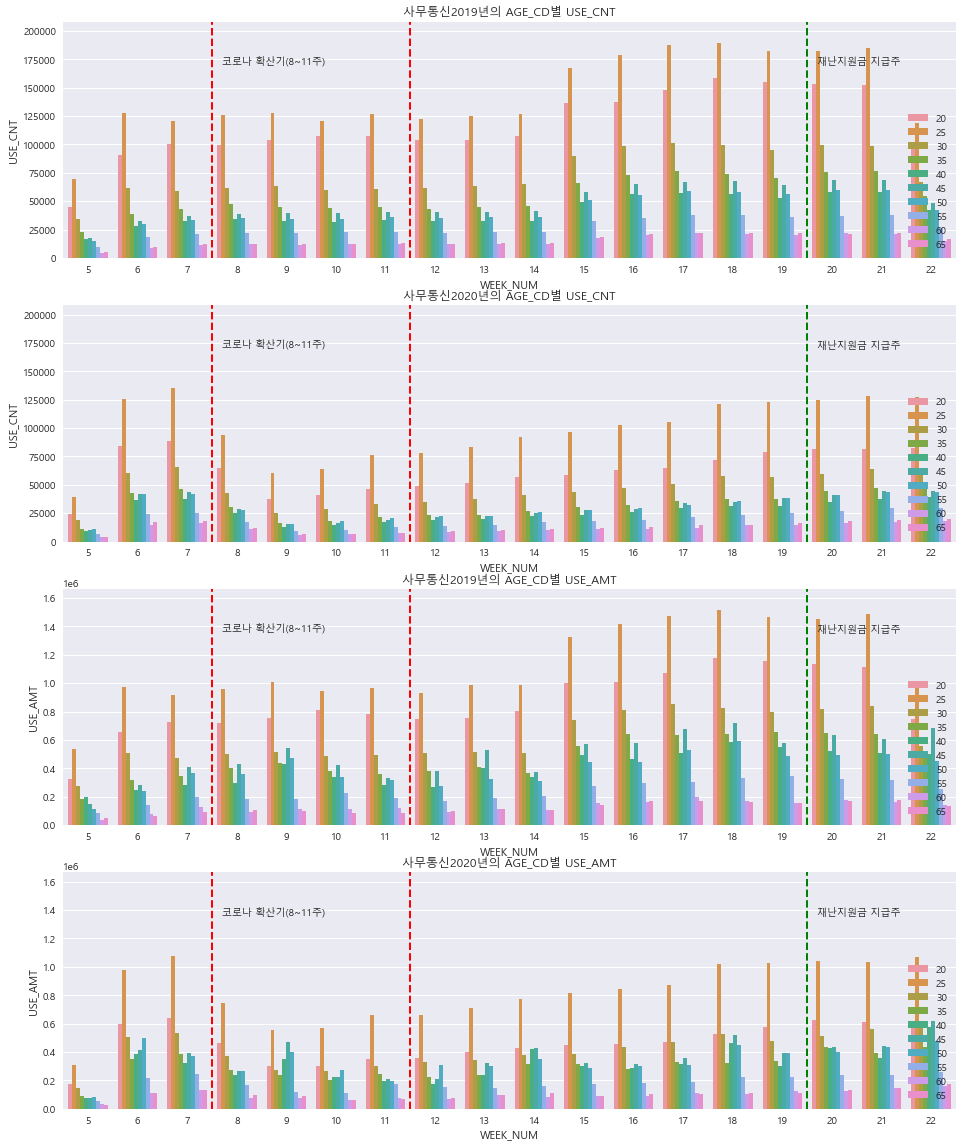

In [12]:
graph_by_month_number_offline("사무통신", "AGE_CD")

### (3) 19년과 20년의 요일별 비중 변화

In [13]:
def graph_by_weekday_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 년도 + 요일별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEKDAY', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    df_2019 = category_df.query('YEAR==2019')
    df_2020 = category_df.query('YEAR==2020')
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    sns.barplot(x=hue_column, y='USE_CNT', hue='WEEKDAY', data=df_2019, ax=axes[0][0])
    sns.barplot(x=hue_column, y='USE_CNT', hue='WEEKDAY', data=df_2020, ax=axes[0][1])
    sns.barplot(x=hue_column, y='USE_AMT', hue='WEEKDAY', data=df_2019, ax=axes[1][0])
    sns.barplot(x=hue_column, y='USE_AMT', hue='WEEKDAY', data=df_2020, ax=axes[1][1])
    
    aggregate_columns = ['USE_CNT', 'USE_AMT']
    years = [2019, 2020]
    for i in [0, 1]:
        for j in [0, 1]:
            axes[i][j].set_ylim([0, df_2019[aggregate_columns[i]].max()*1.1])
            axes[i][j].set_title("{}년 요일별 {}".format(years[j], aggregate_columns[i]))

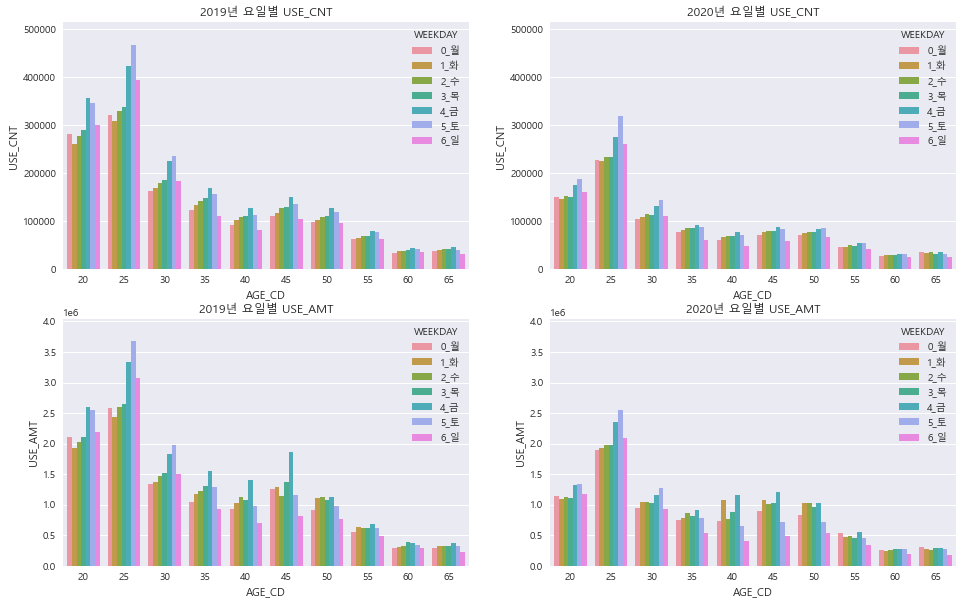

In [14]:
graph_by_weekday_offline("사무통신", "AGE_CD")

## 2. 성별 별로 시간에 따른 변화율 관찰

### (1) 19년과 20년의 월별 비중 변화

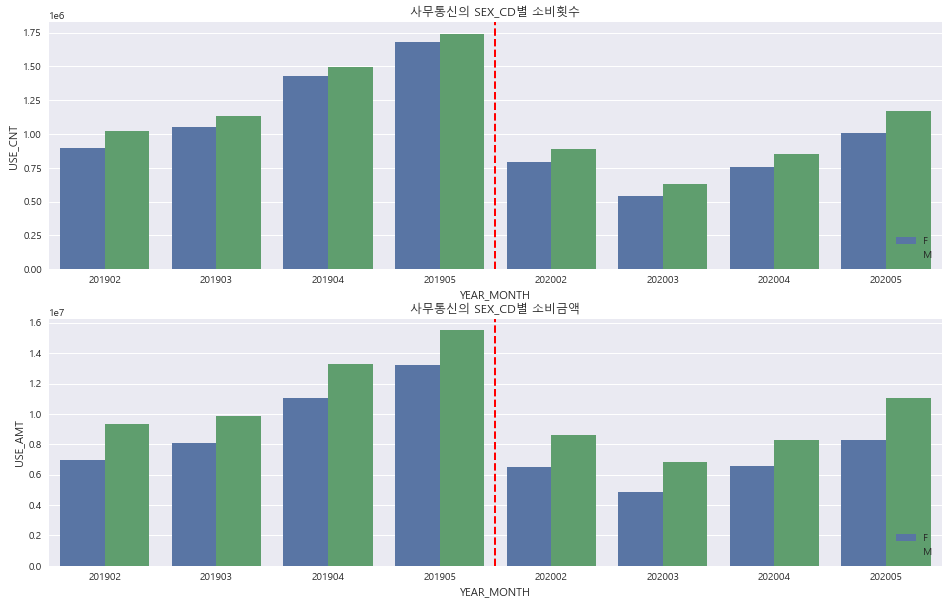

In [15]:
graph_by_year_month_offline("사무통신", "SEX_CD")

### (2) 19년과 20년의 주별 비중 변화

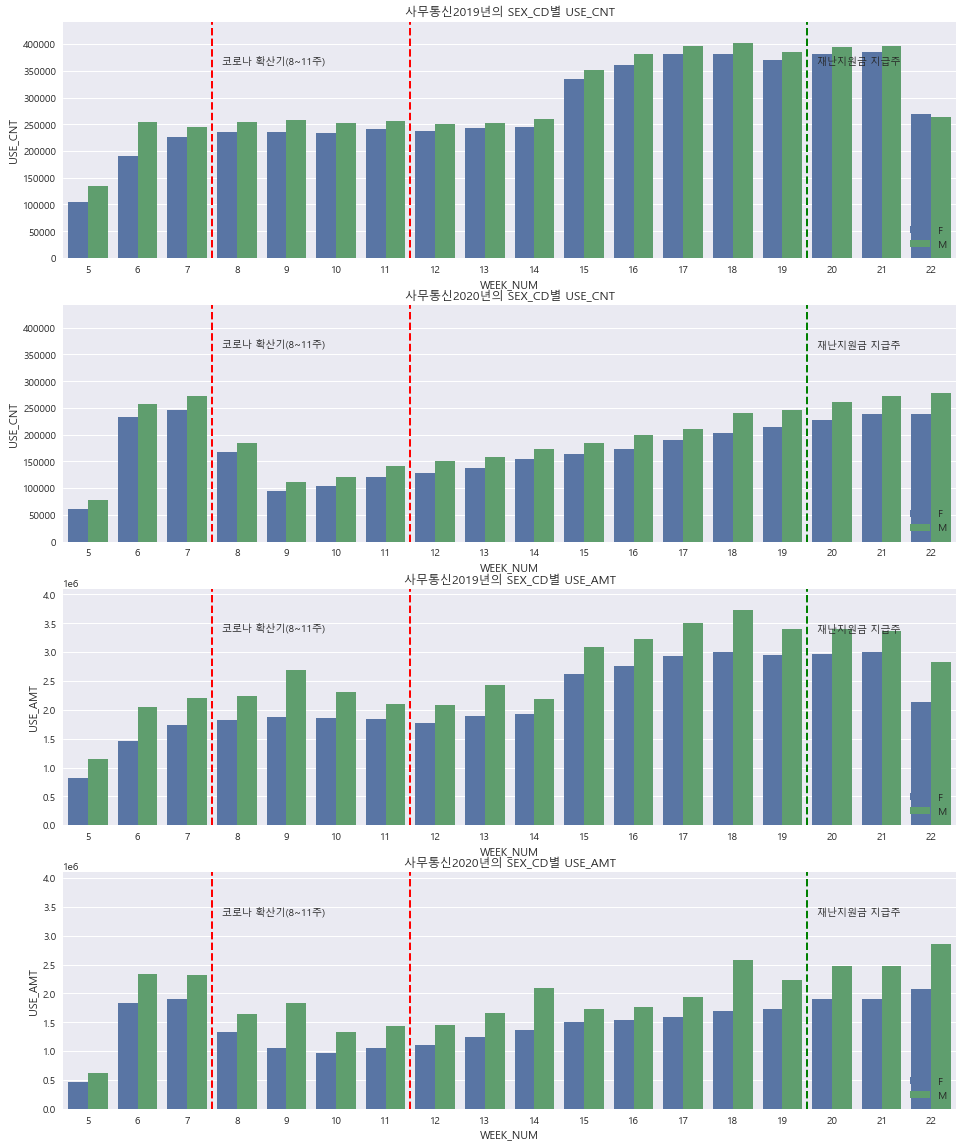

In [16]:
graph_by_month_number_offline("사무통신", "SEX_CD")

### (3) 19년과 20년의 요일별 비중 변화

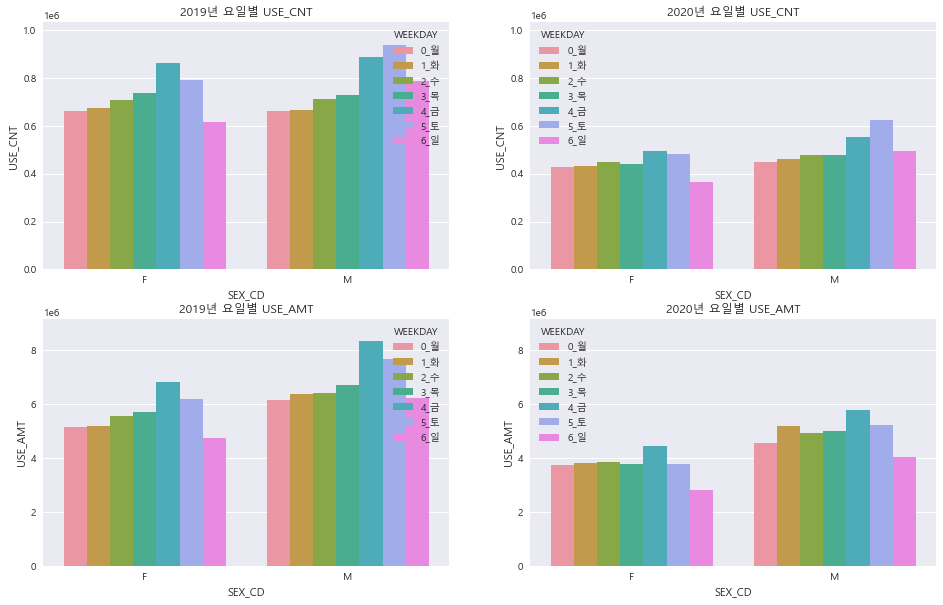

In [17]:
graph_by_weekday_offline("사무통신", "SEX_CD")

## 3. 전체적인 주차별 흐름 관찰

In [18]:
def graph_by_weeknum_offline(category_name, aggregate_column):
    # 지역별 주별 평균을 구하고 -> 이것을 업종별로 합해서 그 업종 추이를 보고자 하였다
    week_df = offline.groupby(['MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'YEAR', 'WEEK_NUM', 'SEX_CD', 'AGE_CD'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['MCT_CAT_CD', 'YEAR', 'WEEK_NUM'])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['MCT_CAT_CD']==category_name, :]
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    plt.figure(figsize=(16, 5))
    ax = sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue='YEAR', data=week_df, palette="Set2")
    ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    ax.legend([2019, 2020])
    ax.axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
    ax.axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
    ax.set_ylim([0, week_df[aggregate_column].max()*1.1])
    ax.text(x=max_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
         fontsize=12)
    ax.text(x=disaster_support_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　재난지원금\n　(2020.05.13)',
         fontsize=12)
    ax.set_title("주차별 {} {}".format(category_name, aggregate_column.upper()), fontsize=12)
    
    
def graph_by_weeknum_with_hue_offline(category_name, aggregate_column, hue_column):
    week_df = offline.groupby(['MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'YEAR', 'WEEK_NUM', 'SEX_CD', 'AGE_CD'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['MCT_CAT_CD', 'YEAR', 'WEEK_NUM', hue_column])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['MCT_CAT_CD']==category_name, :]
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    year_2019_df = week_df.loc[week_df['YEAR']==2019, :]
    year_2020_df = week_df.loc[week_df['YEAR']==2020, :]

    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]
    hue_columns = list(set(week_df[hue_column]))
    hue_columns.sort()
    len_rows = len(set(week_df[hue_column]))

    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2019_df, palette="Set2", ax=axes[0])
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2020_df, palette="Set2", ax=axes[1])
    for i in [0, 1]:
        year = 2019 if i==0 else 2020
        axes[i].set_ylim([0, week_df[aggregate_column].max()*1.1])
        axes[i].legend(loc='lower left')
        axes[i].set_xticks(list(set(week_df['WEEK_NUM'])))
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title("{}년도".format(year))

    fig, axes = plt.subplots(nrows=len_rows, figsize=(16, 5*len_rows))
    for i, select in enumerate(hue_columns):
        temp_2019 = year_2019_df.loc[year_2019_df[hue_column]==select, :]
        temp_2020 = year_2020_df.loc[year_2020_df[hue_column]==select, :]

        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2019, ax=axes[i], palette='Set2')
        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2020, ax=axes[i], palette='Set2')
        axes[i].set_ylim(0, max([temp_2019[aggregate_column].max(), temp_2020[aggregate_column].max()])*1.1)
        axes[i].set_xticks(list(set(week_df['WEEK_NUM'])))
        axes[i].legend([2019, 2020], loc='upper left')
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title(select)
        axes[i].text(x=max_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
                     fontsize=12)
        axes[i].text(x=disaster_support_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　재난지원금\n　(2020.05.13)',
                     fontsize=12)

    plt.show()

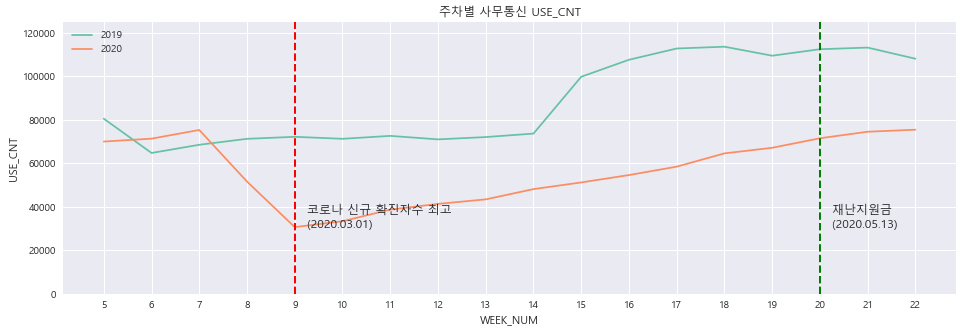

In [19]:
graph_by_weeknum_offline("사무통신", "USE_CNT")

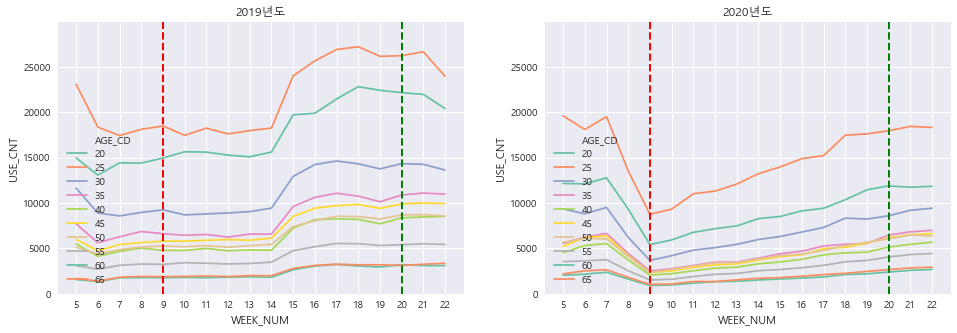

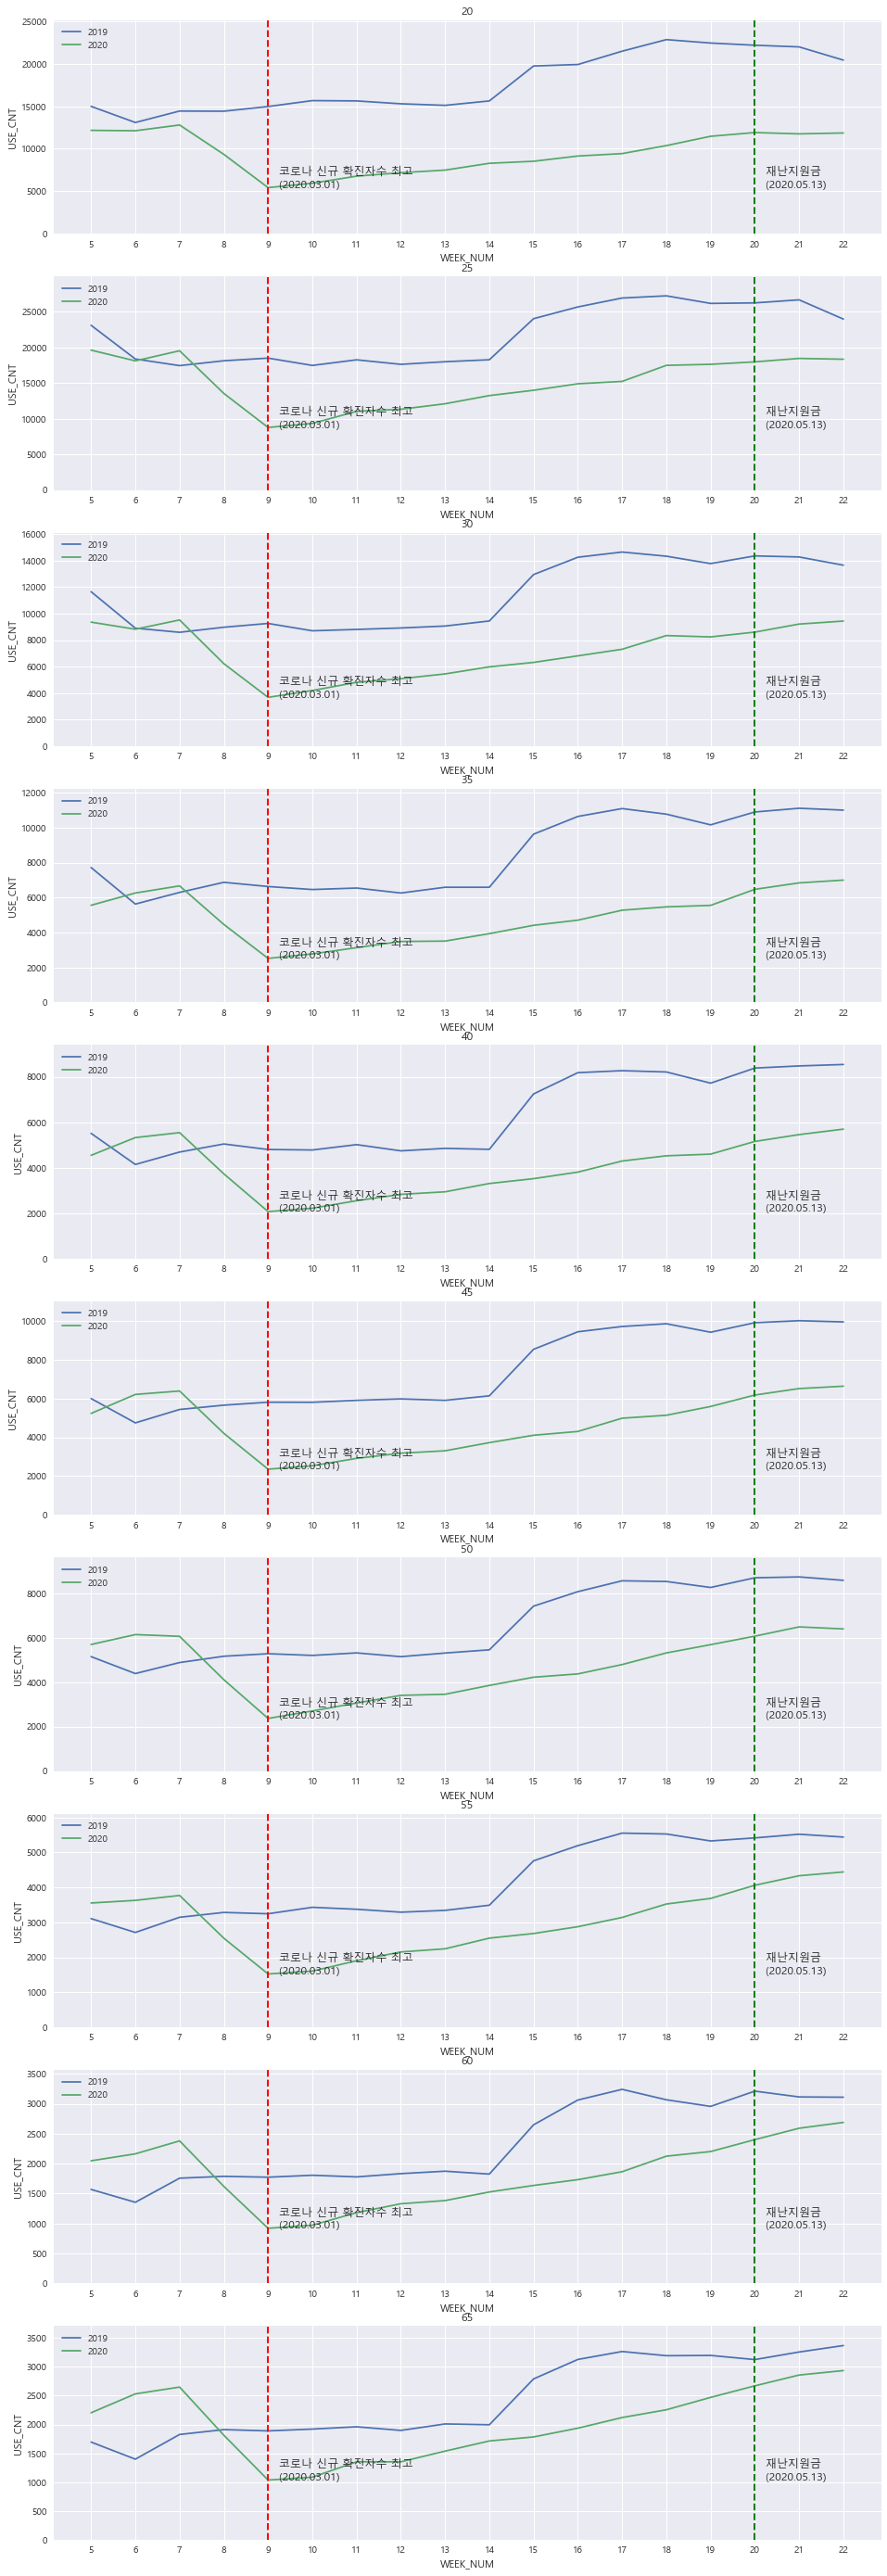

In [20]:
graph_by_weeknum_with_hue_offline("사무통신", "USE_CNT", "AGE_CD")

# Fashion

In [21]:
offline_fashion = offline.loc[(offline['MCT_CAT_CD'] == '의복') | (offline['MCT_CAT_CD'] == '신변잡화'), :]

In [22]:
offline_fashion = offline_fashion.groupby(['STD_DD','YEAR','GU_CD', 'DONG_CD','AGE_CD', 'WEEK_NUM','WEEKDAY'])['USE_CNT', 'USE_AMT'].sum().reset_index()

In [23]:
offline_fashion

,STD_DD,YEAR,GU_CD,DONG_CD,AGE_CD,WEEK_NUM,WEEKDAY,USE_CNT,USE_AMT
0,2019-02-01,2019,대구 수성구,고산1동,20,5,4_금,5,164
1,2019-02-01,2019,대구 수성구,고산1동,25,5,4_금,10,154
2,2019-02-01,2019,대구 수성구,고산1동,30,5,4_금,5,35
3,2019-02-01,2019,대구 수성구,고산1동,35,5,4_금,5,186
4,2019-02-01,2019,대구 수성구,고산1동,40,5,4_금,21,621
...,...,...,...,...,...,...,...,...,...
74147,2020-05-31,2020,서울 중구,회현동,45,22,6_일,79,2260
74148,2020-05-31,2020,서울 중구,회현동,50,22,6_일,84,3019
74149,2020-05-31,2020,서울 중구,회현동,55,22,6_일,84,2311
74150,2020-05-31,2020,서울 중구,회현동,60,22,6_일,33,868


In [38]:
offline_fashion.to_csv('offline_fashion.csv', encoding='euc-kr', index = False)

# Index

In [24]:
group_col='MCT_CAT_CD'
val='USE_CNT'

# Impact index with R(i)

In [39]:
offline_for_index = pd.read_csv("offline_for_index.csv" , encoding='euc-kr')

In [168]:
def impact_index(df, region_col = 'GU_CD',group_col='MCT_CAT_CD', val='USE_CNT'):
    cat_list = df[group_col].unique().tolist()
    impact_index_dict = {}
    
    for cat in cat_list:
        tmp_df = df.loc[df[group_col]== cat]
        
        tmp_2019 = tmp_df.query('YEAR==2019').reset_index(drop=True)
        tmp_2020 = tmp_df.query('YEAR==2020').reset_index(drop=True)
        
        ### 코로나 터지기 2주전 시점의 평균
        pre_R = tmp_2020.loc[tmp_2020.Covid_class == 'A',val].mean()/tmp_2019.loc[tmp_2019.Covid_class == 'A',val].mean()
        
        ### 이동 평균선 (7일) 구하기
        tmp_2019[val] = round(tmp_2019[val].rolling(window=7, center = True).mean(),2)
        tmp_2020[val] = round(tmp_2020[val].rolling(window=7, center = True).mean(),2)
        
        ### 두 데이터프레임의 index 맞추기.
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']>6, ]
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']<22, ].reset_index(drop = True)
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']>6, ]
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']<22, ].reset_index(drop = True)
        
        ### R_i 구하기.
        r_list = tmp_2020['USE_CNT'] / tmp_2019['USE_CNT']
      
        ### 가장 낮아진 시점 구하기.
        T = np.argmin(r_list[11:35]) + 10
        
        ### Plot 그리기
        ax = r_list.plot(figsize=(16, 6))
        ax.axvline(x=T, color='r', linewidth=2, linestyle='--')
        ax.axvline(x=6, color='r', linewidth=2, linestyle='--')
        plt.title("{} 업종의 코로나 타격까지 걸리는 시간 = {}".format(cat,T), fontsize=14)
        plt.show()
        
        
        ### Impact index 계산
        post_R = r_list.iloc[T]
        impact_index = (pre_R - post_R) / pre_R
        print("{} 업종의 Impact range = {}".format(cat,T))
        print("코로나 터지기 전 R 평균: {}, 터진 후 R 최소: {} -> Impact index = {}".format(pre_R, post_R, impact_index))
        print("________________________________________________")
   
        impact_index_dict[cat] = -impact_index

    return  impact_index_dict

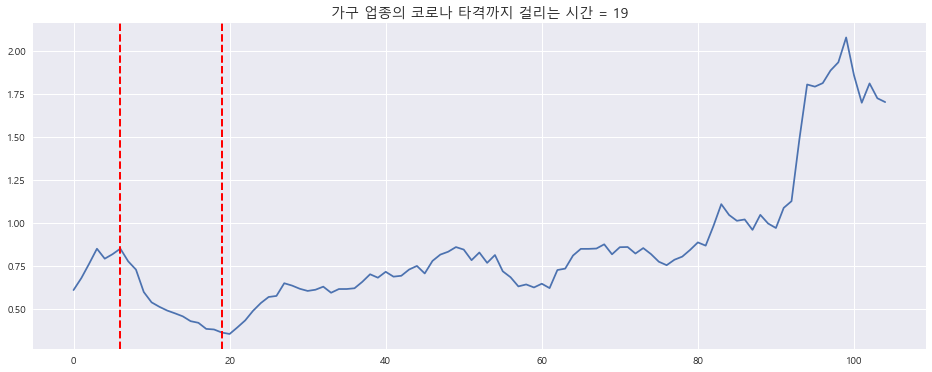

가구 업종의 Impact range = 19
코로나 터지기 전 R 평균: 0.7101642254771416, 터진 후 R 최소: 0.36456430643601595 -> Impact index = 0.4866478859997851
________________________________________________


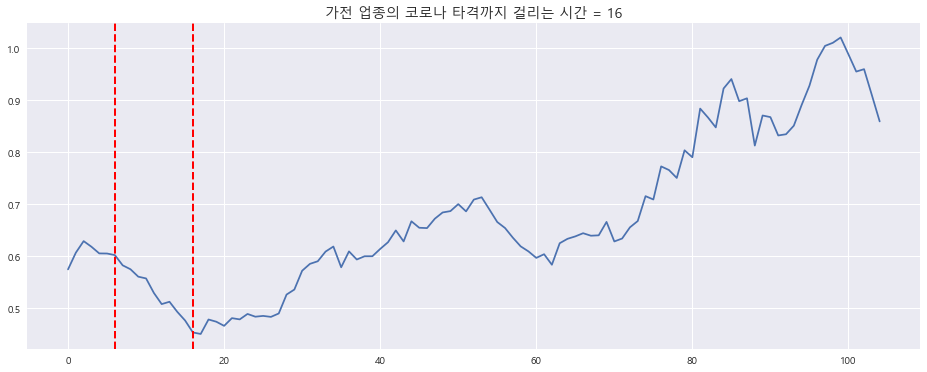

가전 업종의 Impact range = 16
코로나 터지기 전 R 평균: 0.567075459892379, 터진 후 R 최소: 0.4534947572104699 -> Impact index = 0.20029204350240212
________________________________________________


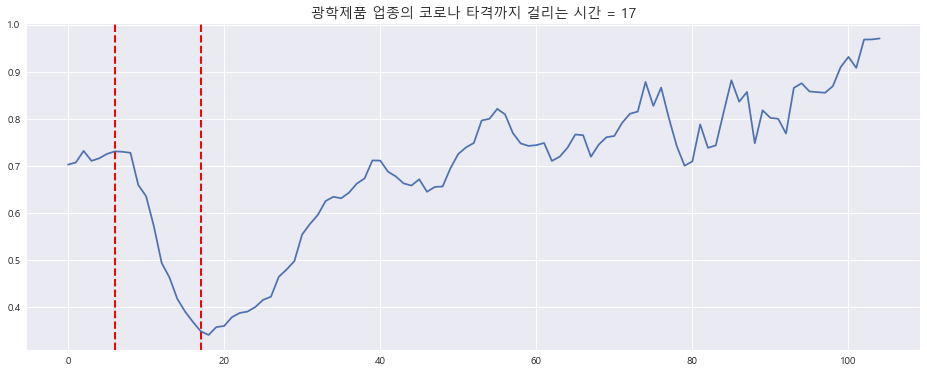

광학제품 업종의 Impact range = 17
코로나 터지기 전 R 평균: 0.6981379023142364, 터진 후 R 최소: 0.34954318552435754 -> Impact index = 0.49932071534052613
________________________________________________


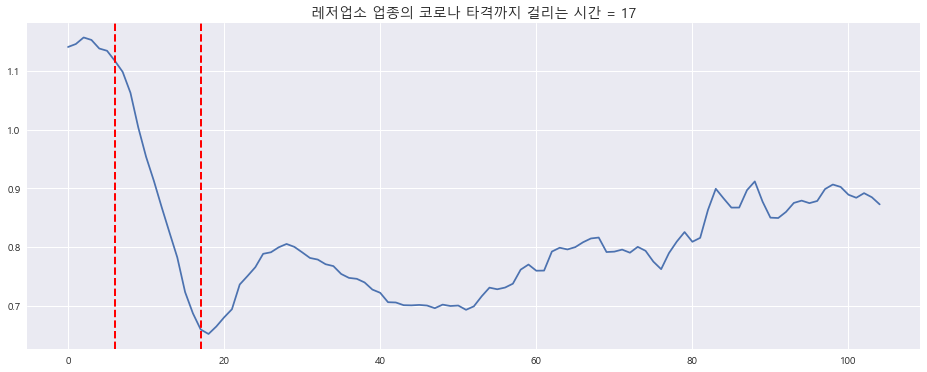

레저업소 업종의 Impact range = 17
코로나 터지기 전 R 평균: 1.1227117899131964, 터진 후 R 최소: 0.6601398669074799 -> Impact index = 0.41201306262356135
________________________________________________


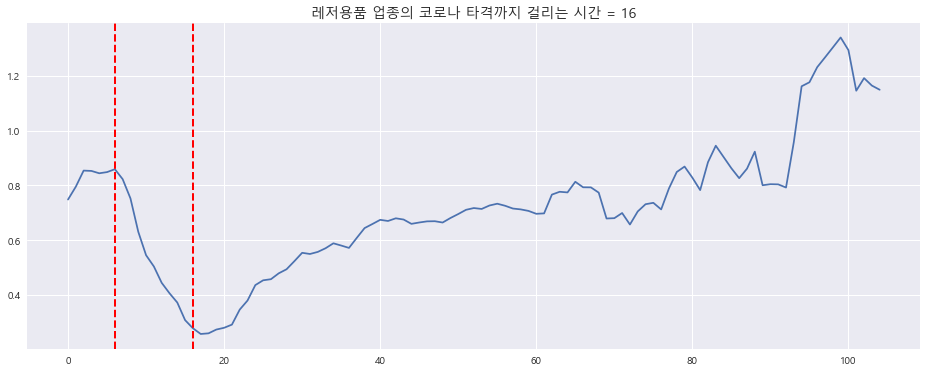

레저용품 업종의 Impact range = 16
코로나 터지기 전 R 평균: 0.78034444955264, 터진 후 R 최소: 0.2797179358352976 -> Impact index = 0.6415455559456394
________________________________________________


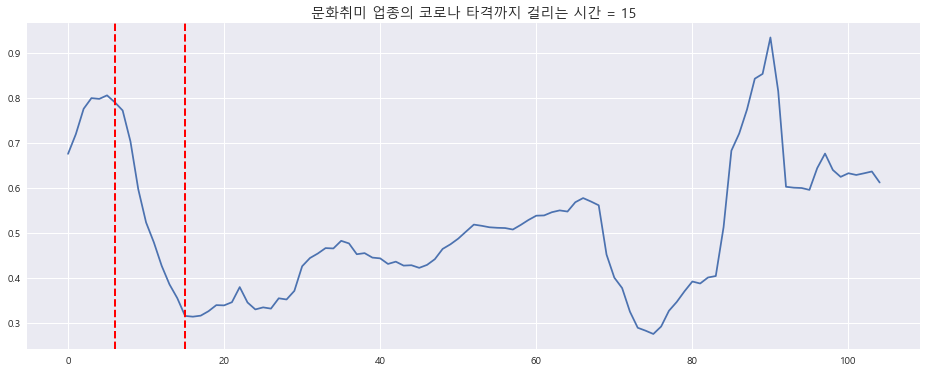

문화취미 업종의 Impact range = 15
코로나 터지기 전 R 평균: 0.7273398128149748, 터진 후 R 최소: 0.3149396621078037 -> Impact index = 0.5669979058496555
________________________________________________


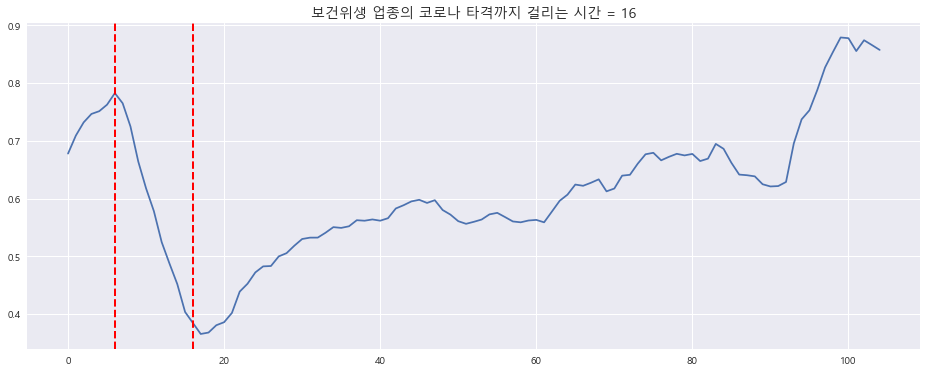

보건위생 업종의 Impact range = 16
코로나 터지기 전 R 평균: 0.7129247790325549, 터진 후 R 최소: 0.3844949076539428 -> Impact index = 0.46067955699939944
________________________________________________


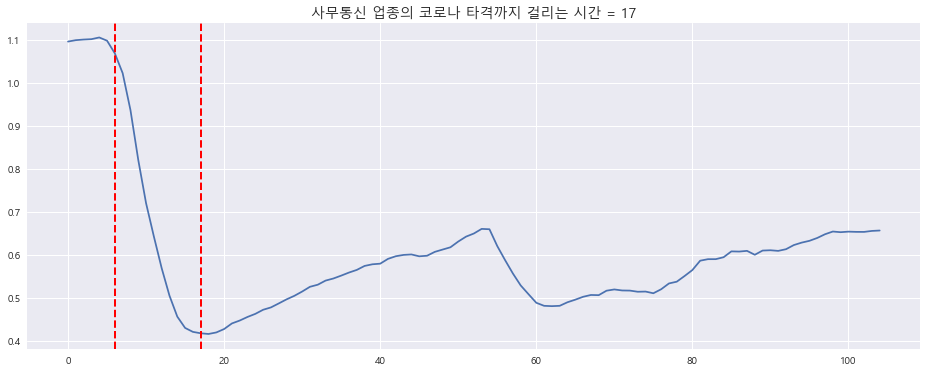

사무통신 업종의 Impact range = 17
코로나 터지기 전 R 평균: 1.084021690813125, 터진 후 R 최소: 0.4177409632863241 -> Impact index = 0.6146378187571354
________________________________________________


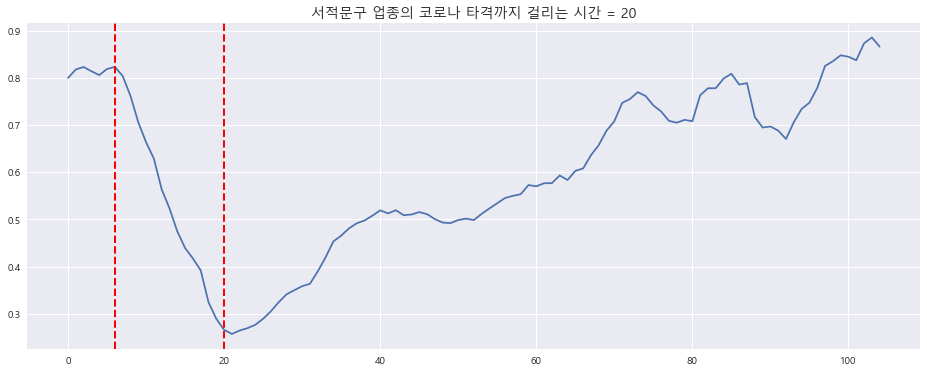

서적문구 업종의 Impact range = 20
코로나 터지기 전 R 평균: 0.8064434882988771, 터진 후 R 최소: 0.2658147502110513 -> Impact index = 0.670386389042877
________________________________________________


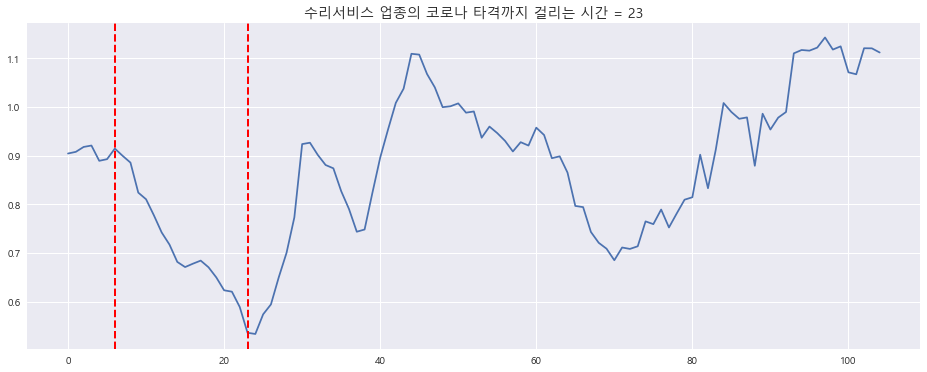

수리서비스 업종의 Impact range = 23
코로나 터지기 전 R 평균: 0.8692379406788439, 터진 후 R 최소: 0.5363730344414821 -> Impact index = 0.38293876815524885
________________________________________________


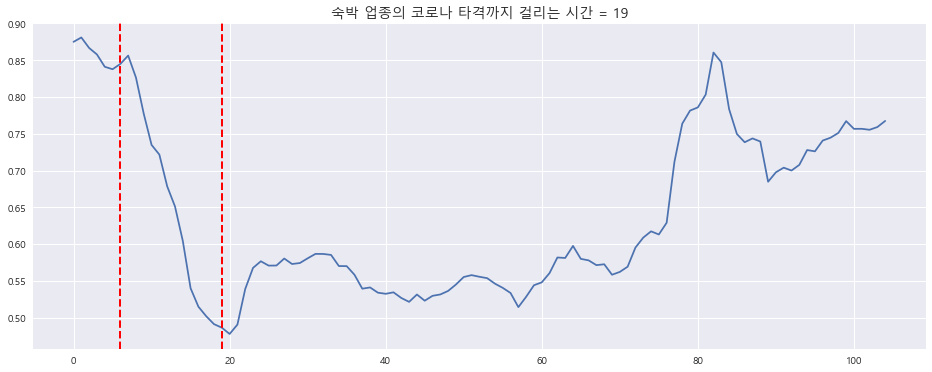

숙박 업종의 Impact range = 19
코로나 터지기 전 R 평균: 0.8720126740148988, 터진 후 R 최소: 0.48627058871801965 -> Impact index = 0.44235834729426027
________________________________________________


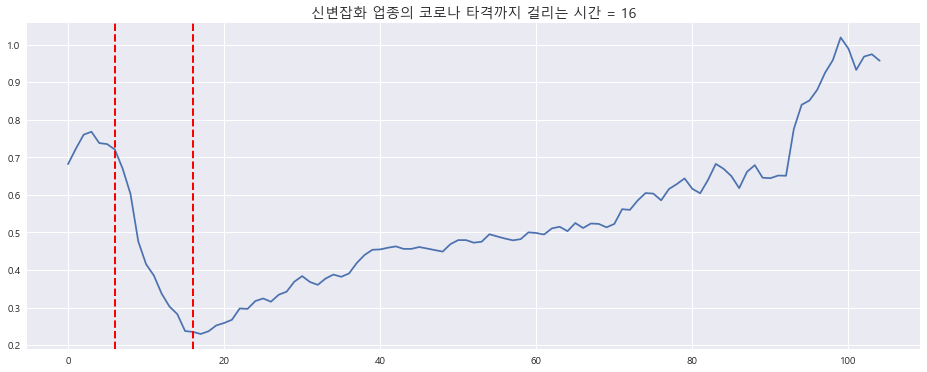

신변잡화 업종의 Impact range = 16
코로나 터지기 전 R 평균: 0.6858857445431545, 터진 후 R 최소: 0.23511705685618728 -> Impact index = 0.6572066722092454
________________________________________________


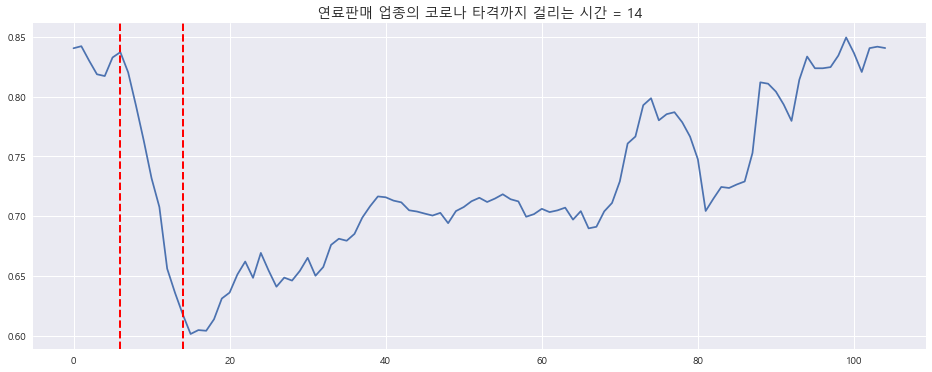

연료판매 업종의 Impact range = 14
코로나 터지기 전 R 평균: 0.8402413739911159, 터진 후 R 최소: 0.6176946952787492 -> Impact index = 0.2648604146392816
________________________________________________


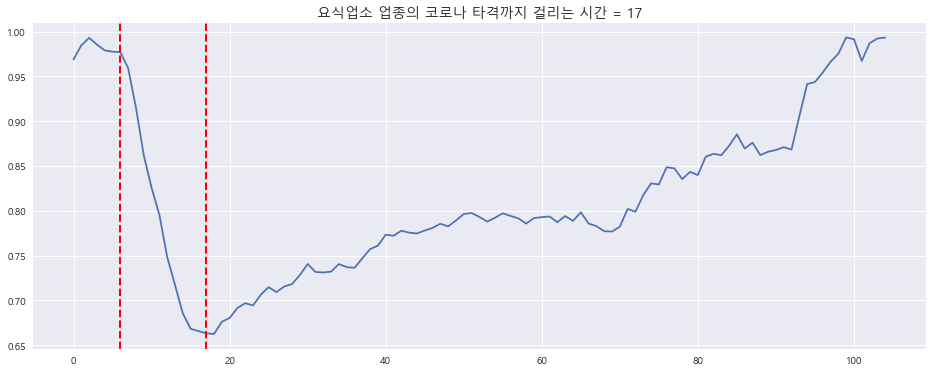

요식업소 업종의 Impact range = 17
코로나 터지기 전 R 평균: 0.9719275334337873, 터진 후 R 최소: 0.6633885626692491 -> Impact index = 0.31745059189184655
________________________________________________


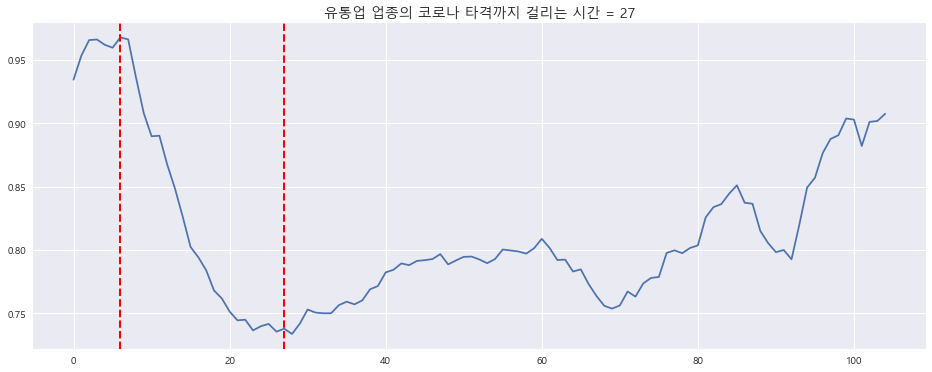

유통업 업종의 Impact range = 27
코로나 터지기 전 R 평균: 0.9534120015702554, 터진 후 R 최소: 0.7377672150075473 -> Impact index = 0.22618216071073616
________________________________________________


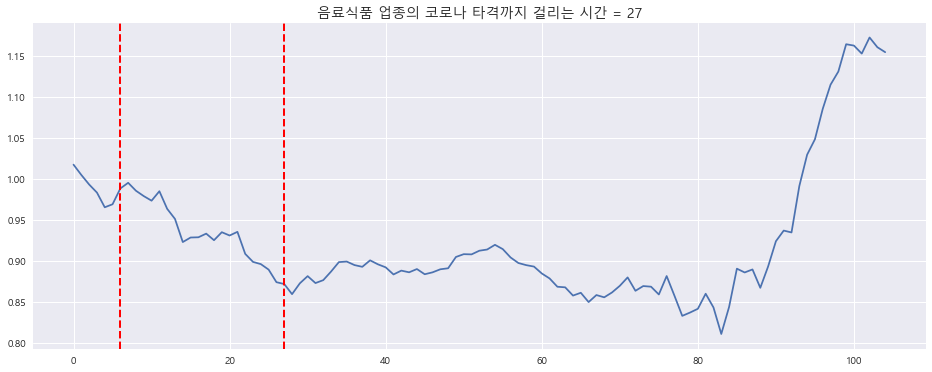

음료식품 업종의 Impact range = 27
코로나 터지기 전 R 평균: 1.0135380526045163, 터진 후 R 최소: 0.8716015763464626 -> Impact index = 0.14004059925852383
________________________________________________


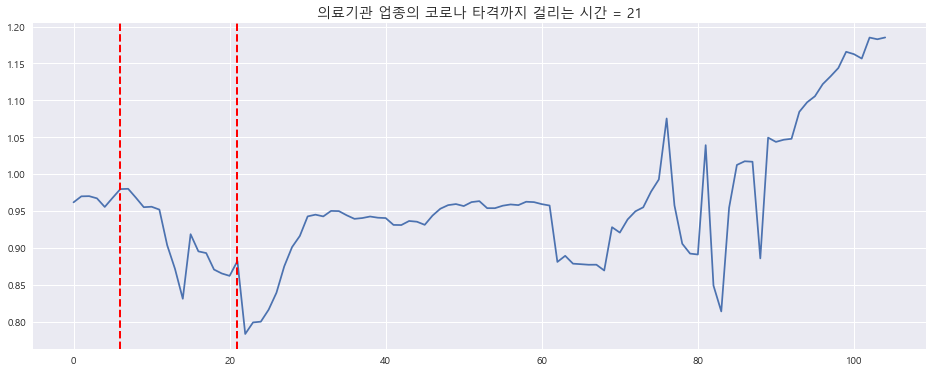

의료기관 업종의 Impact range = 21
코로나 터지기 전 R 평균: 0.9509688860372585, 터진 후 R 최소: 0.8823971922377573 -> Impact index = 0.0721071896318747
________________________________________________


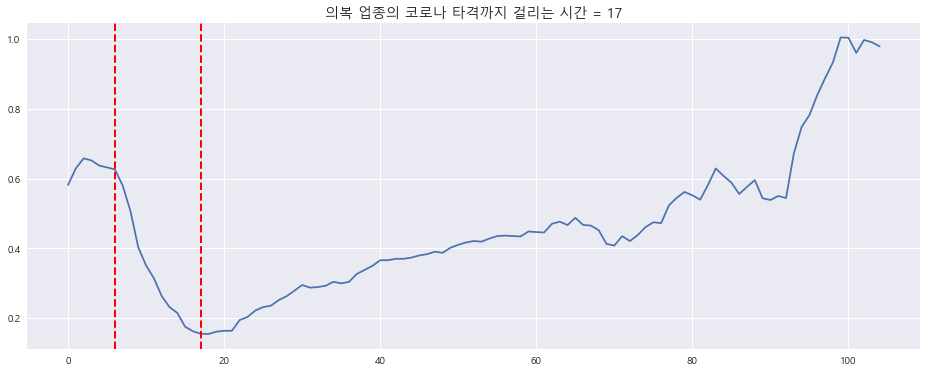

의복 업종의 Impact range = 17
코로나 터지기 전 R 평균: 0.587456057874848, 터진 후 R 최소: 0.15491842310349663 -> Impact index = 0.7362893427911495
________________________________________________


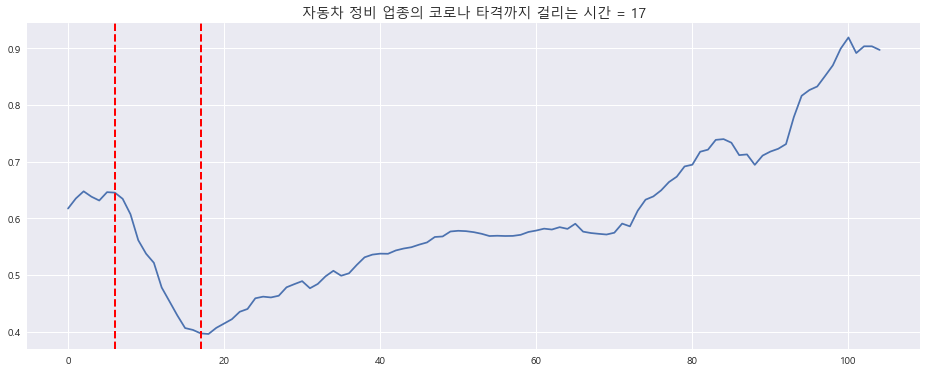

자동차 정비 업종의 Impact range = 17
코로나 터지기 전 R 평균: 0.6308786360804534, 터진 후 R 최소: 0.3967170029559183 -> Impact index = 0.3711674793417373
________________________________________________


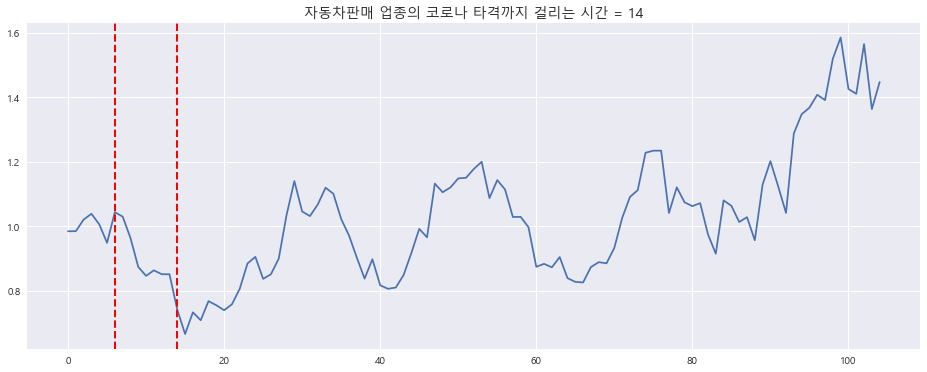

자동차판매 업종의 Impact range = 14
코로나 터지기 전 R 평균: 0.9779559118236472, 터진 후 R 최소: 0.7410657102600231 -> Impact index = 0.2422299397136238
________________________________________________


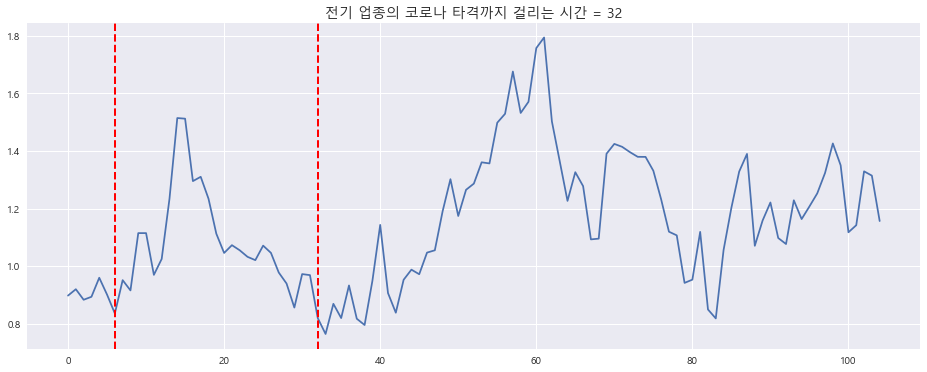

전기 업종의 Impact range = 32
코로나 터지기 전 R 평균: 0.9567809239940387, 터진 후 R 최소: 0.8197388139584671 -> Impact index = 0.1432324857225366
________________________________________________


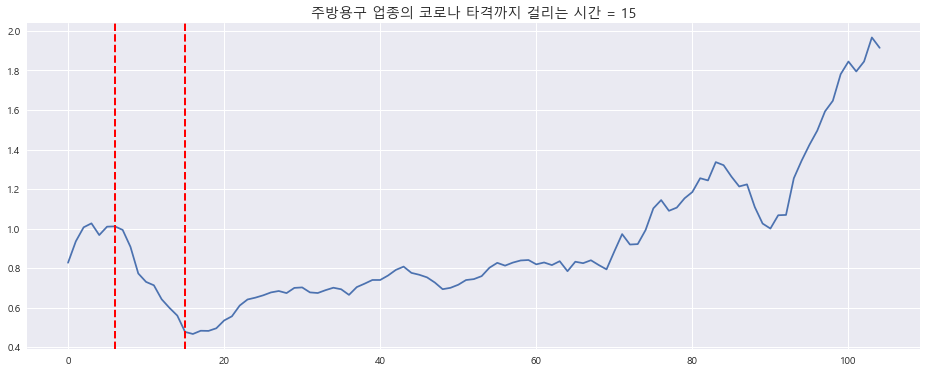

주방용구 업종의 Impact range = 15
코로나 터지기 전 R 평균: 0.9066335476329632, 터진 후 R 최소: 0.47692764231663287 -> Impact index = 0.4739576496349661
________________________________________________


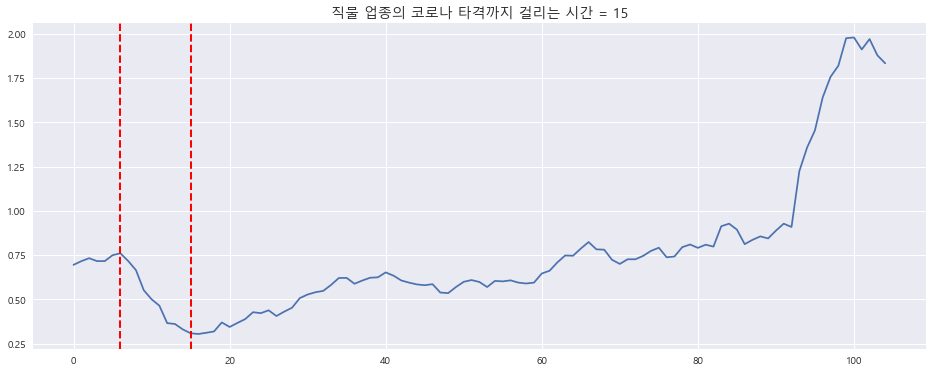

직물 업종의 Impact range = 15
코로나 터지기 전 R 평균: 0.7401918047079337, 터진 후 R 최소: 0.3078214635511403 -> Impact index = 0.5841328401729587
________________________________________________


[('의복', -0.7362893427911495),
 ('서적문구', -0.670386389042877),
 ('신변잡화', -0.6572066722092454),
 ('레저용품', -0.6415455559456394),
 ('사무통신', -0.6146378187571354),
 ('직물', -0.5841328401729587),
 ('문화취미', -0.5669979058496555),
 ('광학제품', -0.49932071534052613),
 ('가구', -0.4866478859997851),
 ('주방용구', -0.4739576496349661),
 ('보건위생', -0.46067955699939944),
 ('숙박', -0.44235834729426027),
 ('레저업소', -0.41201306262356135),
 ('수리서비스', -0.38293876815524885),
 ('자동차 정비', -0.3711674793417373),
 ('요식업소', -0.31745059189184655),
 ('연료판매', -0.2648604146392816),
 ('자동차판매', -0.2422299397136238),
 ('유통업', -0.22618216071073616),
 ('가전', -0.20029204350240212),
 ('전기', -0.1432324857225366),
 ('음료식품', -0.14004059925852383),
 ('의료기관', -0.0721071896318747)]

In [169]:
impact_index_dict = impact_index(offline_for_index, group_col='MCT_CAT_CD', val='USE_CNT')
sorted(impact_index_dict.items(), key = lambda item: item[1])

# Resilience_index

In [38]:
offline.to_csv('offline_raw.csv', encoding='euc-kr', index = False)

In [161]:
def resilience_index(df, group_col='MCT_CAT_CD', val='USE_CNT', window = 4):
    cat_list = df[group_col].unique().tolist()
    resilience_index_dict = {}
    
    for cat in cat_list:
        tmp_df = df.loc[df[group_col]== cat]
        
        tmp_2019 = tmp_df.query('YEAR==2019').reset_index(drop=True)
        tmp_2020 = tmp_df.query('YEAR==2020').reset_index(drop=True)
        
        ### 코로나 터지기 2주전 시점의 평균
        pre_R = tmp_2020.loc[tmp_2020.Covid_class == 'A',val].mean()/tmp_2019.loc[tmp_2019.Covid_class == 'A',val].mean()
        
        ### 이동 평균선 (7일) 구하기
        tmp_2019[val] = round(tmp_2019[val].rolling(window=7, center = True).mean(),2)
        tmp_2020[val] = round(tmp_2020[val].rolling(window=7, center = True).mean(),2)
                
        ### 두 데이터프레임의 index 맞추기.
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']>6, ]
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']<22, ].reset_index(drop = True)
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']>6, ]
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']<22, ].reset_index(drop = True)
        
        ### R_i 구하기.
        r_list = tmp_2020['USE_CNT'] / tmp_2019['USE_CNT']
    
        
        ### 가장 낮아진 시점 구하기.
        T = np.argmin(r_list[10:35].reset_index(drop = True)) + 10
        
        ### Norm (평균값 대비 최소값 0~1 정규화)
        r_list_norm =  [(float(i) - min(r_list))/(pre_R - min(r_list)) for i in r_list] 
        r_list_norm_sample = r_list_norm[(T+1):(1 + T + 7*window)]
        
        ### Resilience index 계산
        temp = []
        for i in range(window):
            sample_list = [x*((window - i)**0.5) for x in r_list_norm_sample[(7*i):(7*(i+1))]]
            temp = temp + sample_list
        Numerator = sum(temp)    
        
        temp = []
        x_square = [x**2 for x in range(1,(1 + 7*window))]
        for i in range(window):
            sample_list = [x*((window - i)**0.5) for x in x_square[(7*i):(7*(i+1))]]
            temp = temp + sample_list
        Dominator = sum(temp) / ((7*window)**2)
        
        Resilience_index = (Numerator/Dominator) * max(r_list_norm_sample)
        
        
        ### R_i 그래프 그리기
        r_list_norm_df = pd.DataFrame(r_list_norm)
        ax = r_list_norm_df[0].plot(figsize=(16, 6))
        for j in range(window + 1):
            ax.axvline(x=(T + 7*j), color='r', linewidth=2, linestyle='--')
        plt.title("{} 업종의 Resilience index = {}".format(cat,Resilience_index), fontsize=14)
        plt.show()
        
        
        resilience_index_dict[cat] = Resilience_index
        
    return  resilience_index_dict

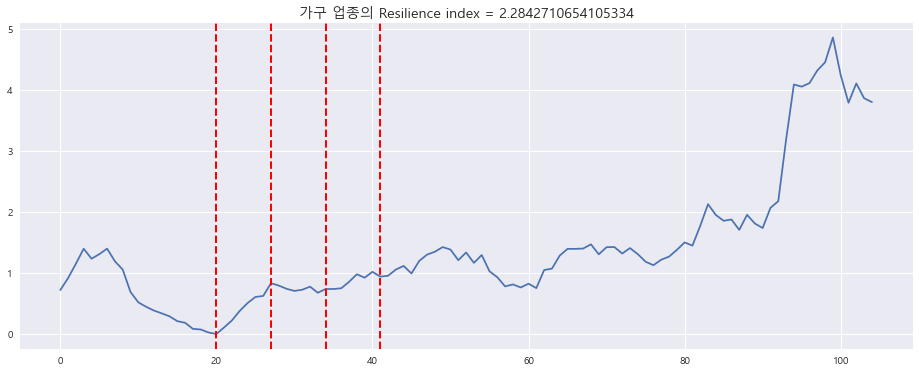

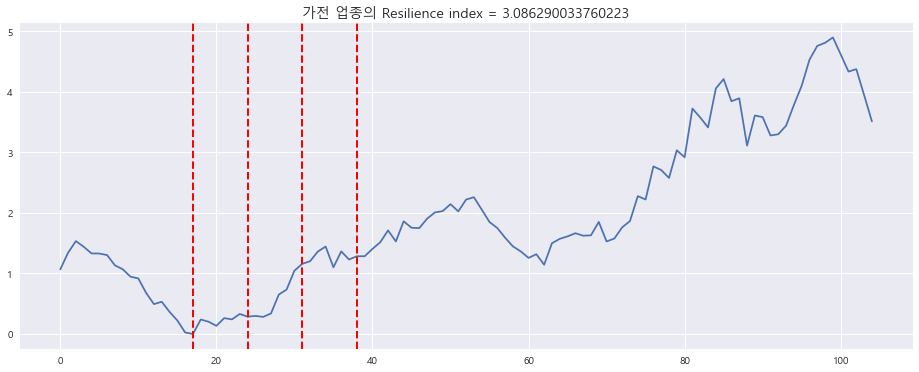

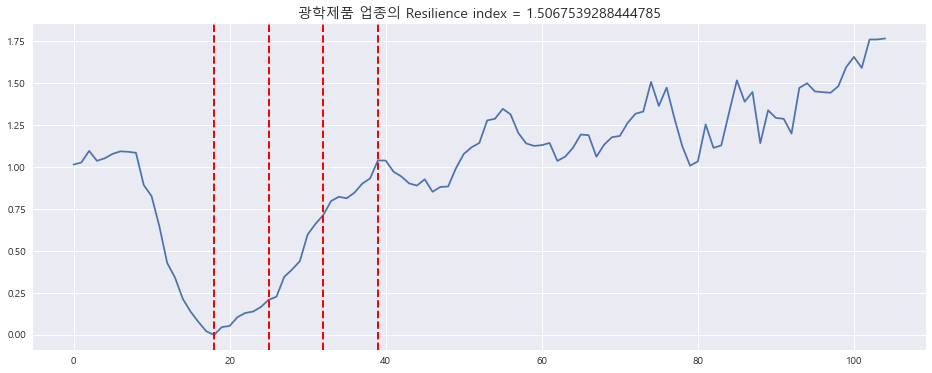

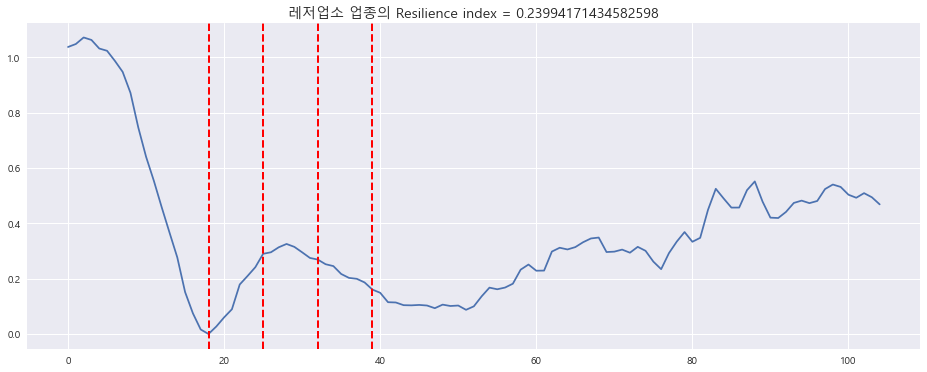

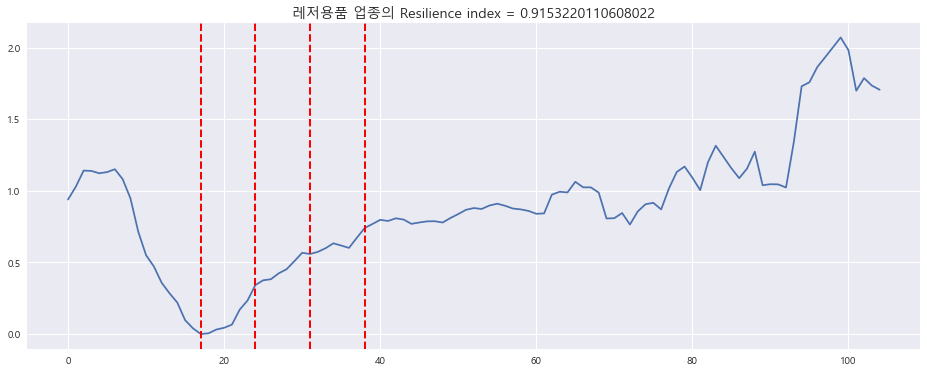

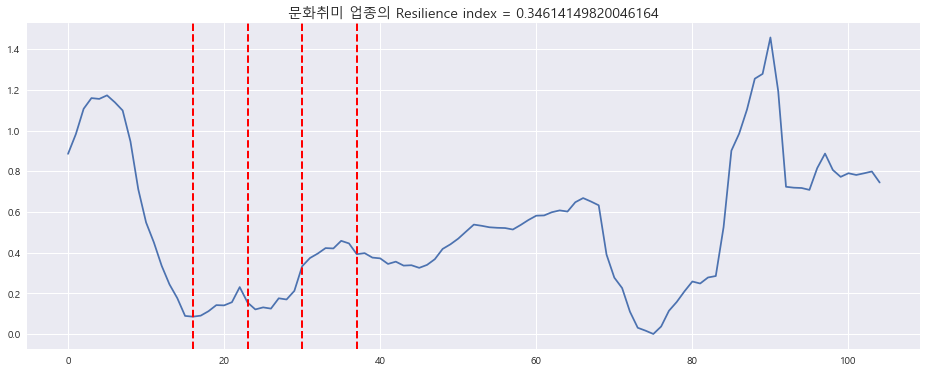

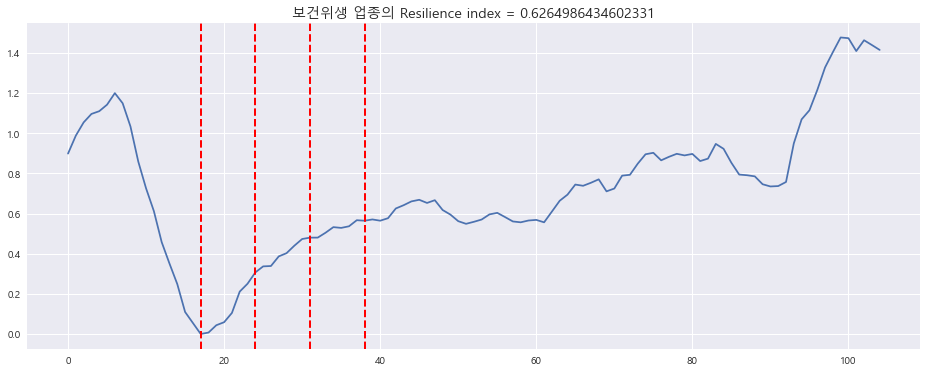

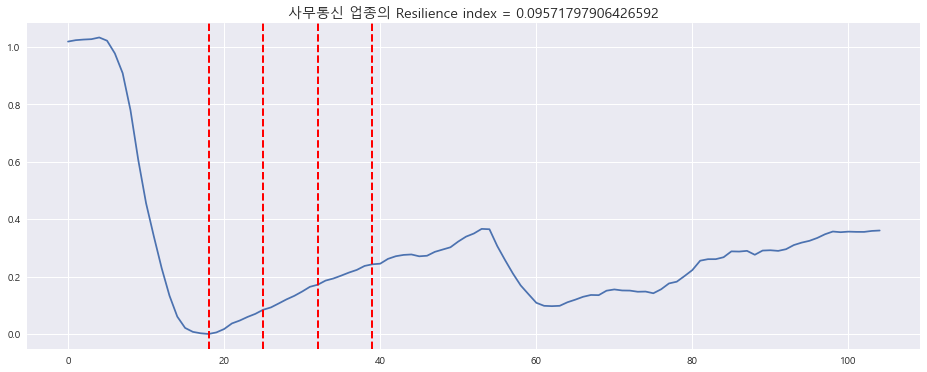

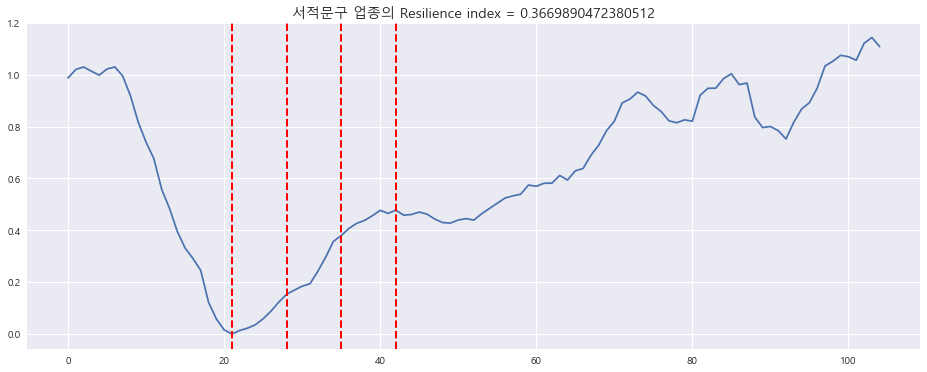

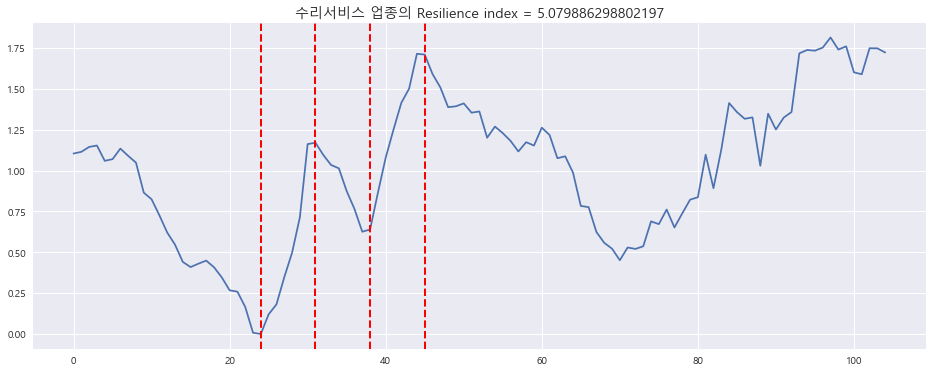

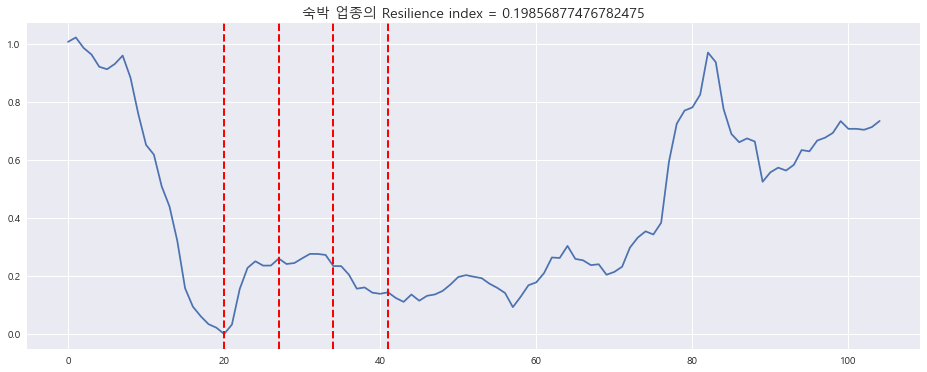

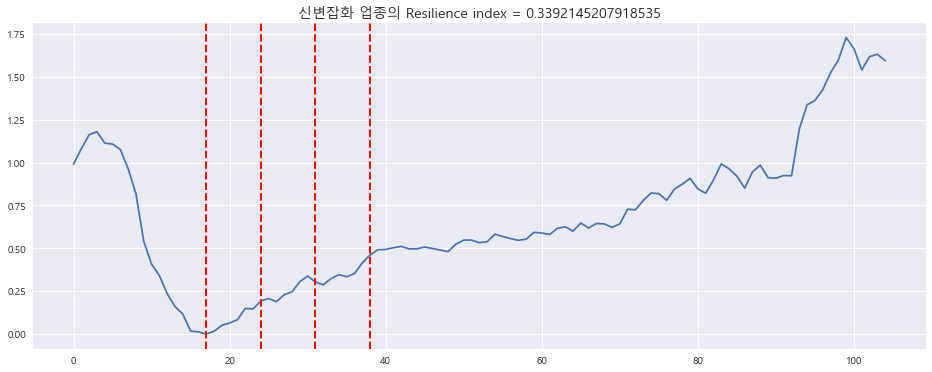

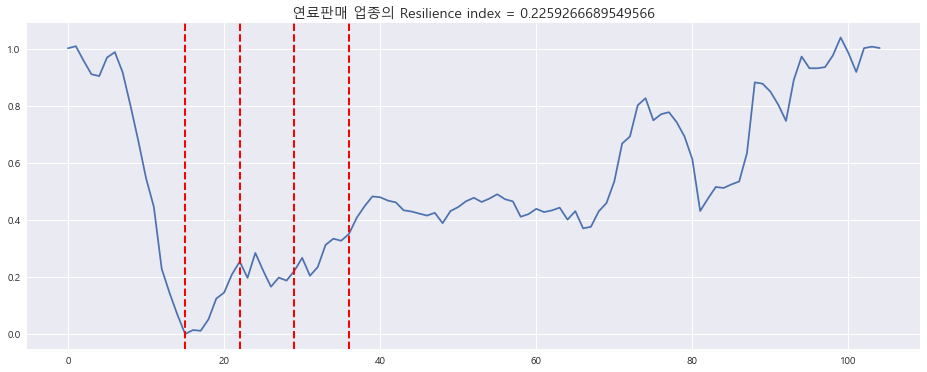

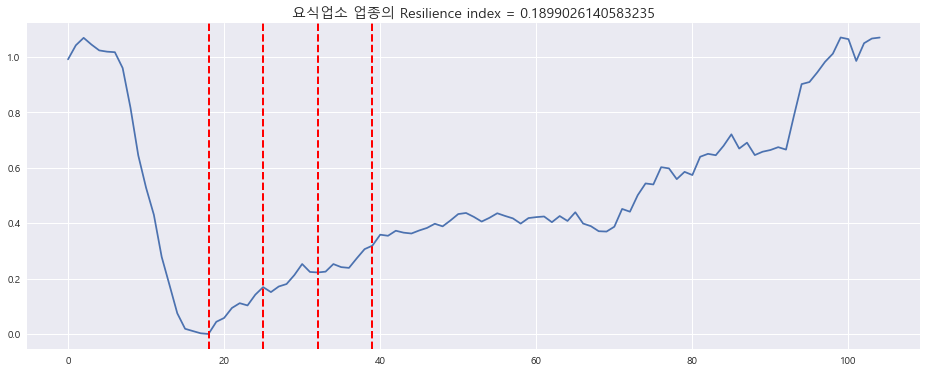

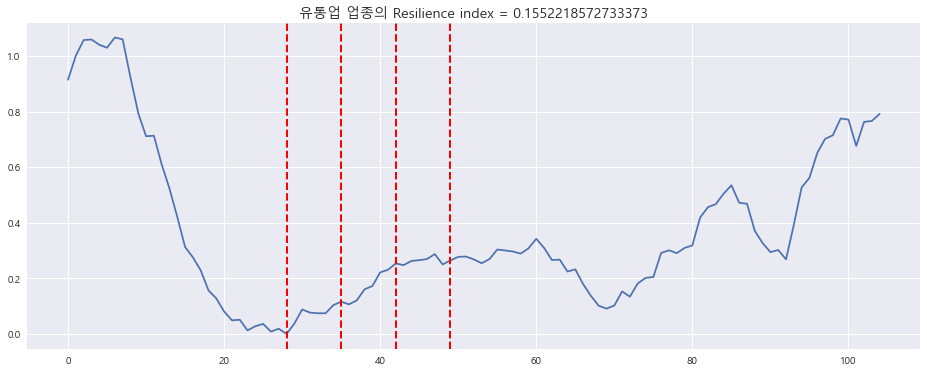

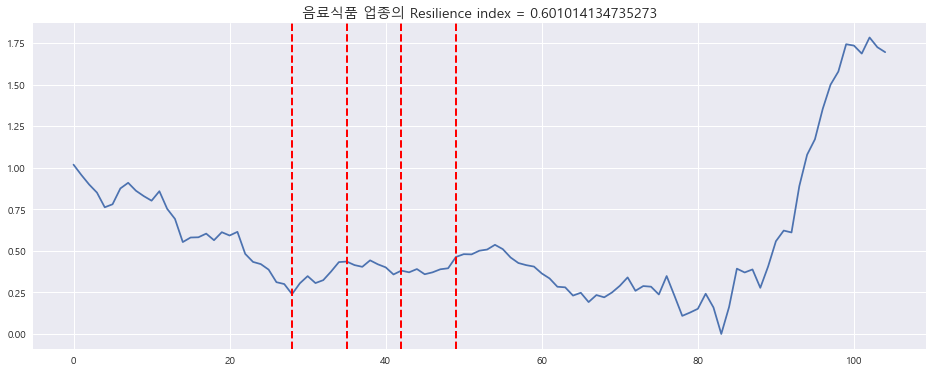

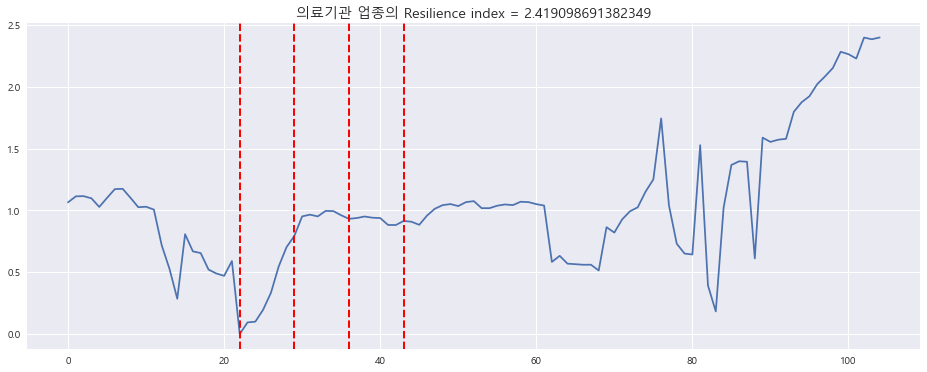

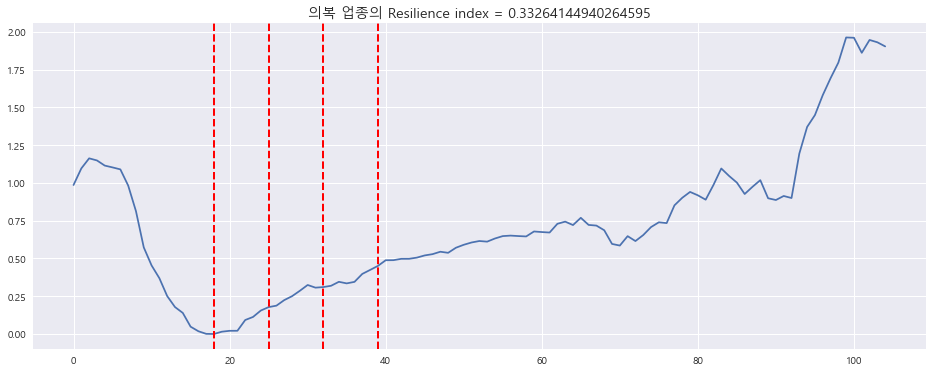

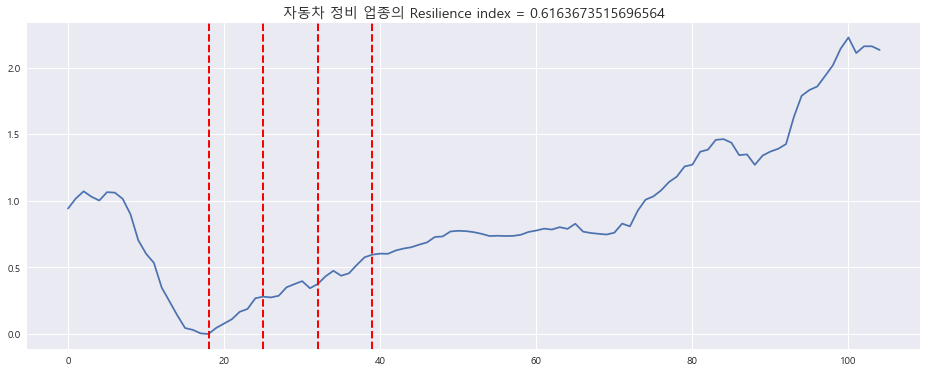

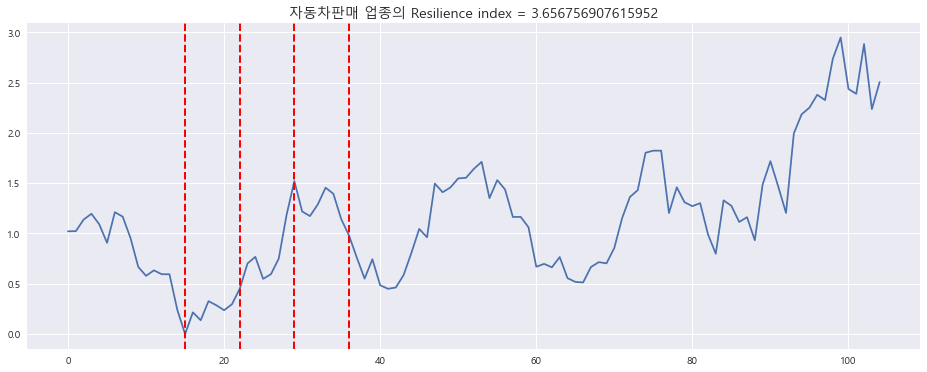

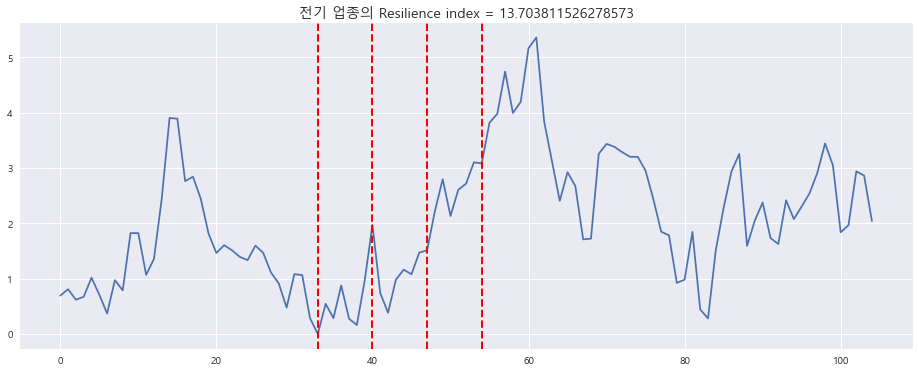

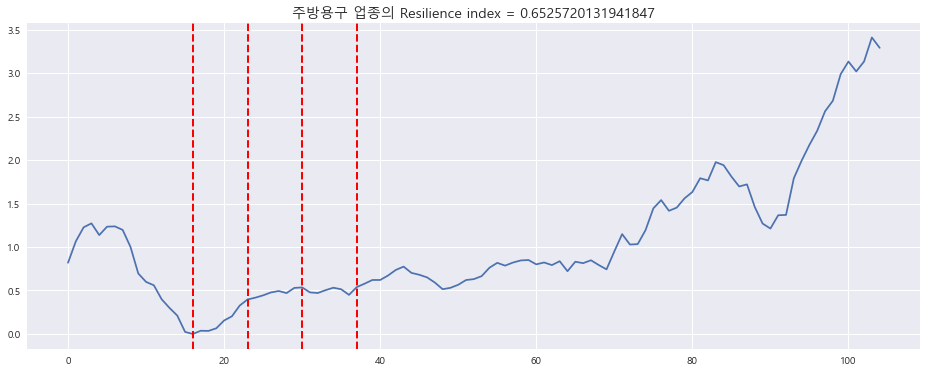

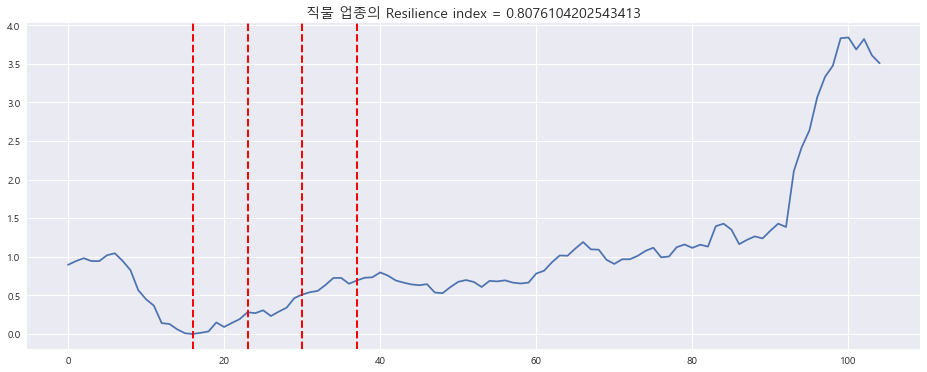

[('사무통신', 0.09571797906426592),
 ('유통업', 0.1552218572733373),
 ('요식업소', 0.1899026140583235),
 ('숙박', 0.19856877476782475),
 ('연료판매', 0.2259266689549566),
 ('레저업소', 0.23994171434582598),
 ('의복', 0.33264144940264595),
 ('신변잡화', 0.3392145207918535),
 ('문화취미', 0.34614149820046164),
 ('서적문구', 0.3669890472380512),
 ('음료식품', 0.601014134735273),
 ('자동차 정비', 0.6163673515696564),
 ('보건위생', 0.6264986434602331),
 ('주방용구', 0.6525720131941847),
 ('직물', 0.8076104202543413),
 ('레저용품', 0.9153220110608022),
 ('광학제품', 1.5067539288444785),
 ('가구', 2.2842710654105334),
 ('의료기관', 2.419098691382349),
 ('가전', 3.086290033760223),
 ('자동차판매', 3.656756907615952),
 ('수리서비스', 5.079886298802197),
 ('전기', 13.703811526278573)]

In [166]:
resilience_index_dict = resilience_index(offline_for_index, group_col='MCT_CAT_CD', val='USE_CNT', window = 3)
sorted(resilience_index_dict.items(), key = lambda item: item[1])

# Clustering

Text(0, 0.5, 'Resilience index')

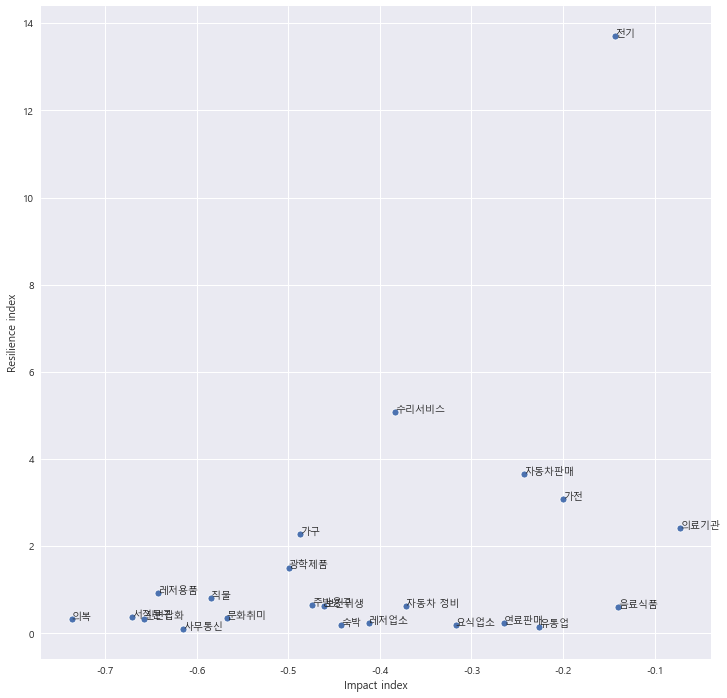

In [170]:
fig, ax = plt.subplots(figsize=(12,12))

x = list(impact_index_dict.values())
y = list(resilience_index_dict.values())

sns.scatterplot(x, y, ax=ax)

for i, label in enumerate(list(impact_index_dict.keys())):
    ax.annotate(f'{label}', (x[i],y[i]))
plt.xlabel("Impact index")
plt.ylabel("Resilience index")



## K_means clustering

In [171]:
df = pd.DataFrame(list(zip(x,y)), index = list(impact_index_dict.keys()), columns = ['Impact', 'Resilience'])

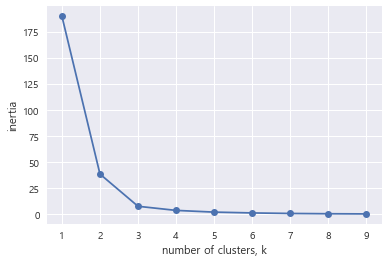

In [172]:
ks = range(1,10)

inertias = []



for k in ks:

    model = KMeans(n_clusters=k)

    model.fit(df)

    inertias.append(model.inertia_)

    

# Plot ks vs inertias

plt.plot(ks, inertias, '-o')

plt.xlabel('number of clusters, k')

plt.ylabel('inertia')

plt.xticks(ks)

plt.show()



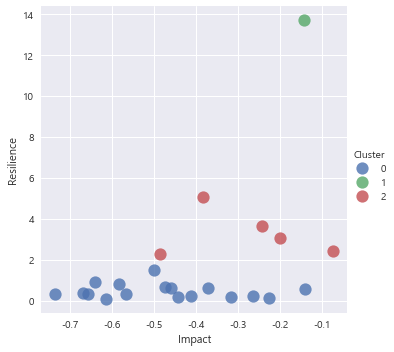

In [173]:
kmeans = KMeans(n_clusters = 3).fit(df.iloc[:,0:2])
df['Cluster'] = kmeans.labels_

sns.lmplot('Impact', 'Resilience', data = df, fit_reg = False,
          scatter_kws = {"s": 150},
          hue = "Cluster")


## Bad 클러스터 내의 클러스터링

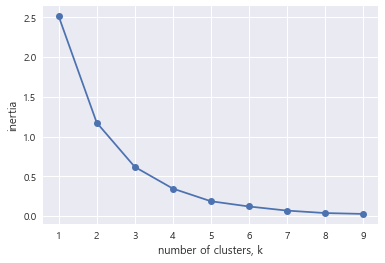

In [174]:
df_bad = df.loc[df['Cluster'] == 0,:]

ks = range(1,10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_bad)
    inertias.append(model.inertia_)
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [175]:
df_bad["Field"] = list(df_bad.index)

In [176]:
df_bad

,Impact,Resilience,Cluster,Field
광학제품,-0.499321,1.506754,0,광학제품
레저업소,-0.412013,0.239942,0,레저업소
레저용품,-0.641546,0.915322,0,레저용품
문화취미,-0.566998,0.346141,0,문화취미
보건위생,-0.460680,0.626499,0,보건위생
사무통신,-0.614638,0.095718,0,사무통신
서적문구,-0.670386,0.366989,0,서적문구
숙박,-0.442358,0.198569,0,숙박
신변잡화,-0.657207,0.339215,0,신변잡화
연료판매,-0.264860,0.225927,0,연료판매


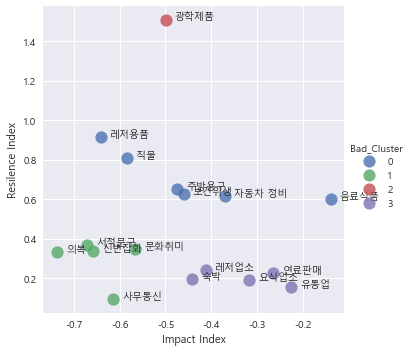

In [178]:
kmeans_bad = KMeans(n_clusters = 4).fit(df_bad.iloc[:,0:2])
df_bad['Bad_Cluster'] = kmeans_bad.labels_

ax = sns.lmplot('Impact', 'Resilience', data = df_bad, fit_reg = False,
                scatter_kws = {"s": 150},
                hue = "Bad_Cluster")

plt.xlabel("Impact Index")
plt.ylabel("Resilence Index")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_bad.Impact, df_bad.Resilience, df_bad.Field, plt.gca())  
             

# 도시별 Impact index 계산

In [132]:
def impact_index_region(df, Region = '서울',region_col = 'DONG_CD',field ='의복', val='USE_CNT'):
    impact_index_region_dict = {}
    field_df = df.loc[df['MCT_CAT_CD']== field]
    field_df = field_df.loc[field_df['Region']== Region]
    cat_list = field_df[region_col].unique().tolist()
    
    for cat in cat_list:
        tmp_df = field_df.loc[field_df[region_col]== cat]
        tmp_2019 = tmp_df.query('YEAR==2019').reset_index(drop=True)
        tmp_2020 = tmp_df.query('YEAR==2020').reset_index(drop=True)
        tmp_2019 = tmp_2019.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
        tmp_2020 = tmp_2020.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
        
        ### 코로나 터지기 1주전 시점의 평균
        pre_2019 = tmp_2019.iloc[13:20,6].mean()
        pre_2020 = tmp_2020.iloc[11:18,6].mean()
        
        pre_R = tmp_2020.iloc[6:20,6]/tmp_2019.iloc[7:21,6]
        pre_R = pre_R.mean()
        
        ### 이동 평균선 (7일) 구하기
        tmp_2019[val] = round(tmp_2019[val].rolling(window=7, center = True).mean(),2)
        tmp_2020[val] = round(tmp_2020[val].rolling(window=7, center = True).mean(),2)
        
        ### 두 데이터프레임의 index 맞추기.
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']>6, ]
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']<22, ].reset_index(drop = True)
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']>6, ]
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']<22, ].reset_index(drop = True)
        
        ### R_i 구하기.
        r_list = tmp_2020['USE_CNT'] / tmp_2019['USE_CNT']
      
        ### 가장 낮아진 시점 구하기.
        T = np.argmin(r_list[11:35])
        
        ### Plot 그리기
        ax = r_list.plot(figsize=(16, 6))
        ax.axvline(x=T, color='r', linewidth=2, linestyle='--')
        ax.axvline(x=7, color='r', linewidth=2, linestyle='--')
        plt.title("{}의 {} 행정동의 코로나 타격까지 걸리는 시간 = {}".format(Region, cat,T), fontsize=14)
        plt.show()
        
        
        ### Impact index 계산
        post_R = r_list.iloc[T]
        impact_index = (pre_R - post_R) / pre_R
        print("{}의 {} 행정동의 Impact range = {}".format(Region, cat, T))
        print("코로나 터지기 전 R 평균: {}, 터진 후 R 최소: {} -> Impact index = {}".format(pre_R, post_R, impact_index))
        print("________________________________________________")
   
        impact_index_region_dict[cat] = impact_index

    return  impact_index_region_dict

In [136]:
impact_index_region_dict = {}
field_df = df.loc[df['MCT_CAT_CD']== field]
field_df = field_df.loc[field_df['Region']== Region]
cat = '중림동'

tmp_df = field_df.loc[field_df[region_col]== cat]
tmp_2019 = tmp_df.query('YEAR==2019').reset_index(drop=True)
tmp_2020 = tmp_df.query('YEAR==2020').reset_index(drop=True)
tmp_2019 = tmp_2019.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
tmp_2020 = tmp_2020.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
        
        ### 코로나 터지기 1주전 시점의 평균
pre_2019 = tmp_2019.iloc[13:20,6].mean()
pre_2020 = tmp_2020.iloc[11:18,6].mean()
        
pre_R = tmp_2020.iloc[6:20,6]/tmp_2019.iloc[7:21,6]
pre_R = pre_R.mean()
        
        ### 이동 평균선 (7일) 구하기
tmp_2019[val] = round(tmp_2019[val].rolling(window=7, center = True).mean(),2)
tmp_2020[val] = round(tmp_2020[val].rolling(window=7, center = True).mean(),2)
        
        ### 두 데이터프레임의 index 맞추기.
tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']>6, ]
tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']<22, ].reset_index(drop = True)
tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']>6, ]
tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']<22, ].reset_index(drop = True)
        
        ### R_i 구하기.
r_list = tmp_2020['USE_CNT'] / tmp_2019['USE_CNT']
      
        ### 가장 낮아진 시점 구하기.
T = np.argmin(r_list[11:35])
        

In [141]:
impact_index_region_dict = {}
field_df = df.loc[df['MCT_CAT_CD']== field]
field_df = field_df.loc[field_df['Region']== Region]
cat = '중림동'

tmp_df = field_df.loc[field_df[region_col]== cat]
tmp_2019 = tmp_df.query('YEAR==2019').reset_index(drop=True)
tmp_2020 = tmp_df.query('YEAR==2020').reset_index(drop=True)
tmp_2019 = tmp_2019.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
tmp_2020 = tmp_2020.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
  
pre_2019 = tmp_2019.iloc[13:20,:]
pre_2020 = tmp_2020.iloc[11:18,:]

In [142]:
pre_2019

,STD_DD,YEAR,MONTH,DAY,WEEK_NUM,WEEKDAY,USE_CNT
13,2019-05-06,2019,5,6,19,0_월,8
14,2019-05-16,2019,5,16,20,3_목,8
15,2019-05-20,2019,5,20,21,0_월,4
16,2019-05-21,2019,5,21,21,1_화,4
17,2019-05-22,2019,5,22,21,2_수,4
18,2019-05-25,2019,5,25,21,5_토,4


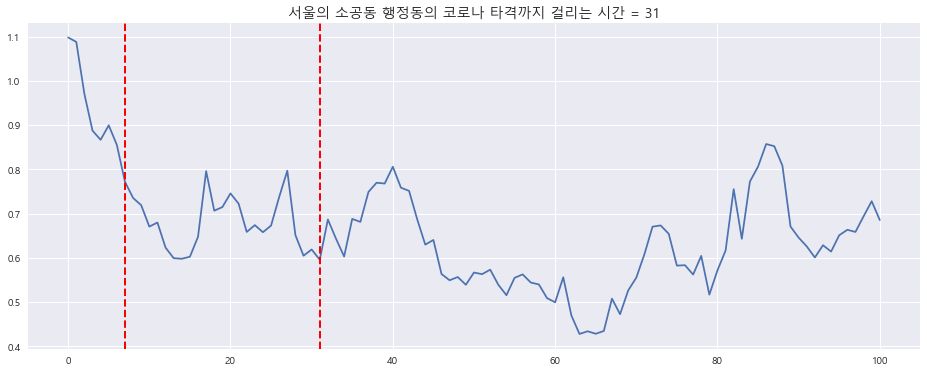

서울의 소공동 행정동의 Impact range = 31
코로나 터지기 전 R 평균: 2.3820101132429317, 터진 후 R 최소: 0.5955780370400587 -> Impact index = 0.749968300416146
________________________________________________


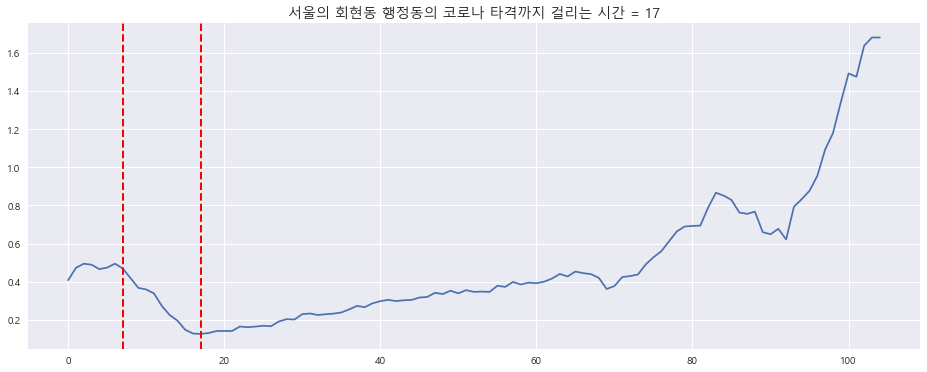

서울의 회현동 행정동의 Impact range = 17
코로나 터지기 전 R 평균: 0.6661305859254701, 터진 후 R 최소: 0.124687064691156 -> Impact index = 0.8128188866783148
________________________________________________


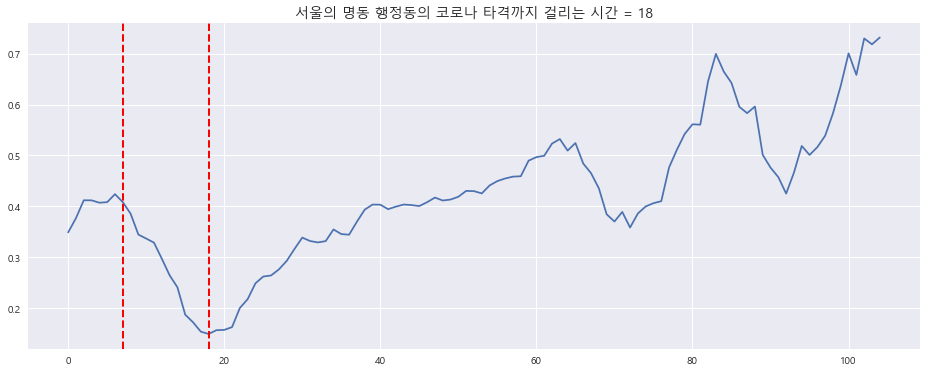

서울의 명동 행정동의 Impact range = 18
코로나 터지기 전 R 평균: 0.40294639673963395, 터진 후 R 최소: 0.14963820549927642 -> Impact index = 0.6286399215626539
________________________________________________


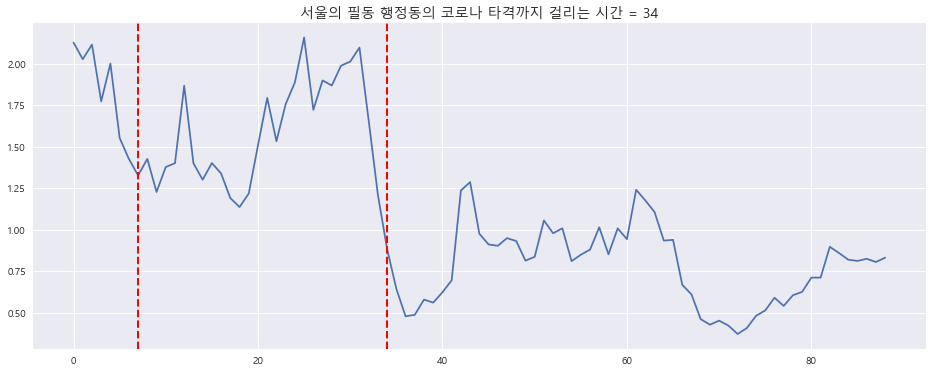

서울의 필동 행정동의 Impact range = 34
코로나 터지기 전 R 평균: 1.4051282051282052, 터진 후 R 최소: 0.8822406110757478 -> Impact index = 0.3721280322636102
________________________________________________


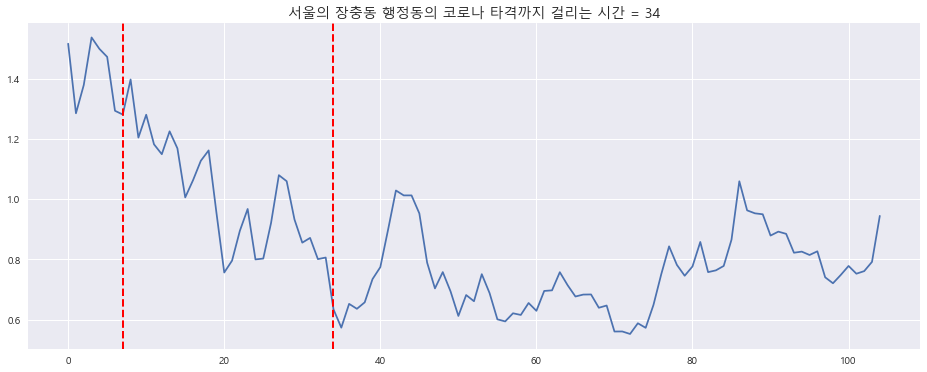

서울의 장충동 행정동의 Impact range = 34
코로나 터지기 전 R 평균: 1.4817551113960559, 터진 후 R 최소: 0.6338094787626526 -> Impact index = 0.5722576059376638
________________________________________________


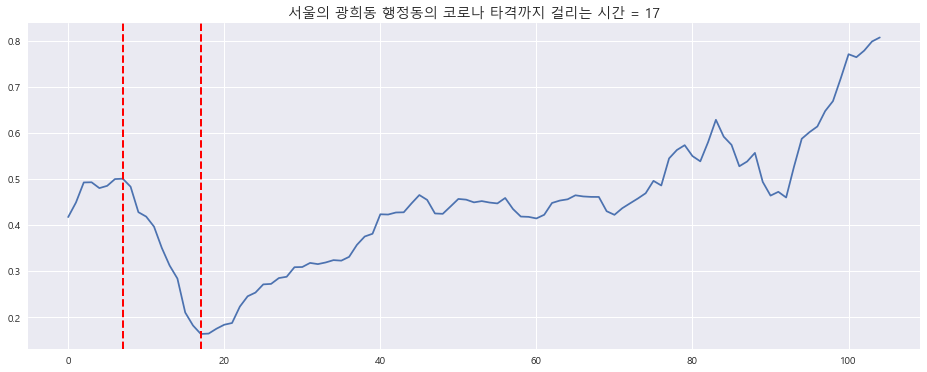

서울의 광희동 행정동의 Impact range = 17
코로나 터지기 전 R 평균: 0.5236426481041202, 터진 후 R 최소: 0.1639376229842403 -> Impact index = 0.6869284356845525
________________________________________________


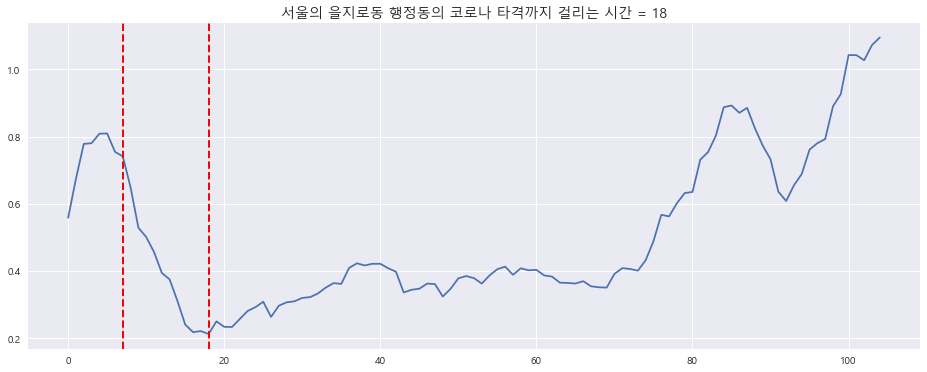

서울의 을지로동 행정동의 Impact range = 18
코로나 터지기 전 R 평균: 0.6379265688635419, 터진 후 R 최소: 0.21323382687472564 -> Impact index = 0.6657392288040315
________________________________________________


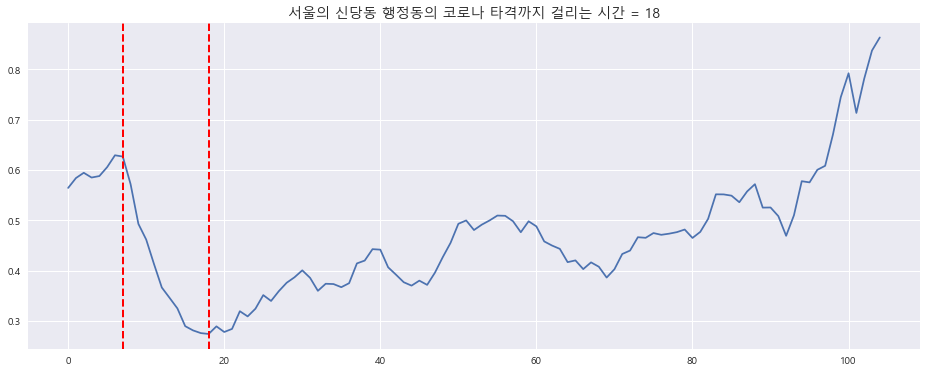

서울의 신당동 행정동의 Impact range = 18
코로나 터지기 전 R 평균: 0.6315405619099276, 터진 후 R 최소: 0.27468623718738233 -> Impact index = 0.5650536897318734
________________________________________________


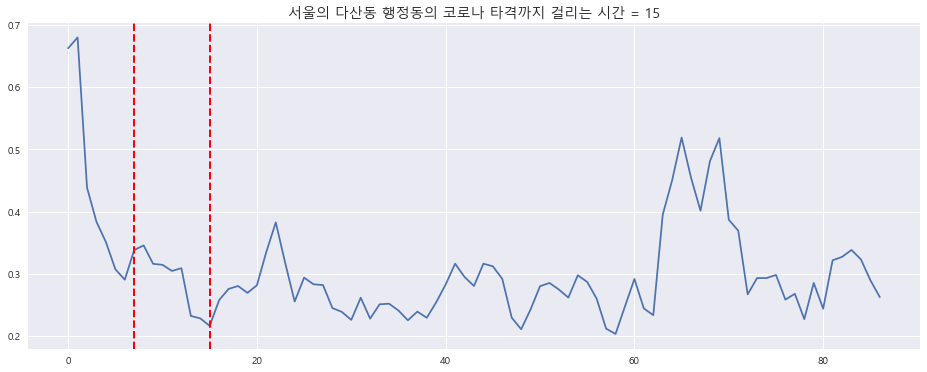

서울의 다산동 행정동의 Impact range = 15
코로나 터지기 전 R 평균: 0.923714349117803, 터진 후 R 최소: 0.21618267560188634 -> Impact index = 0.7659637139897714
________________________________________________


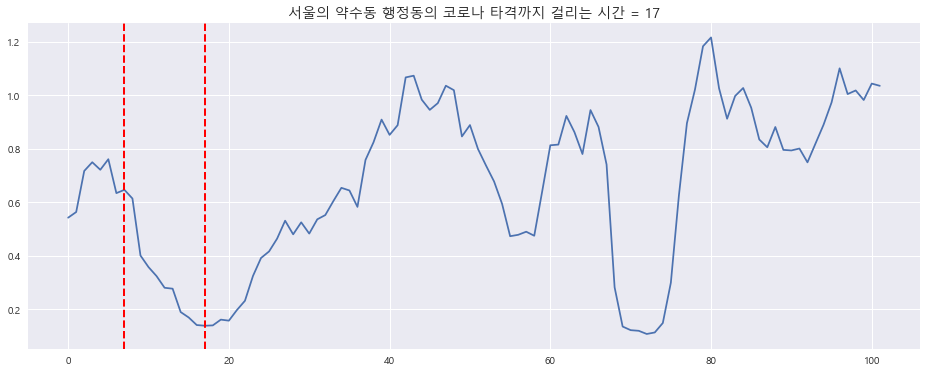

서울의 약수동 행정동의 Impact range = 17
코로나 터지기 전 R 평균: 0.6400993662339098, 터진 후 R 최소: 0.13857347591224783 -> Impact index = 0.7835125556715372
________________________________________________


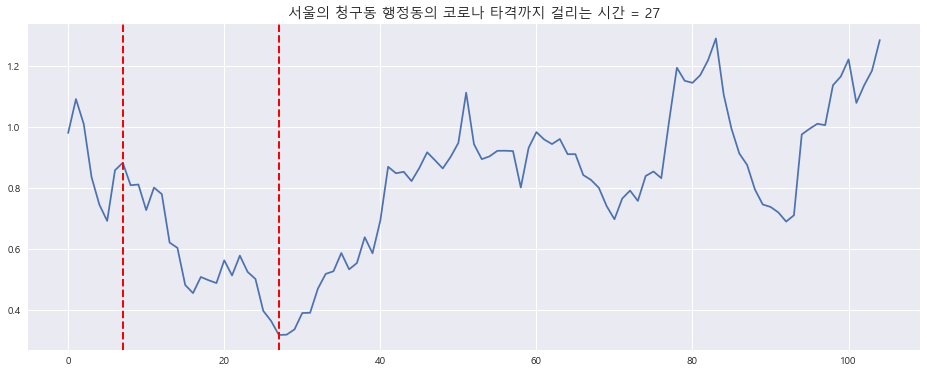

서울의 청구동 행정동의 Impact range = 27
코로나 터지기 전 R 평균: 1.1161146371963584, 터진 후 R 최소: 0.31717274815003826 -> Impact index = 0.7158242195024291
________________________________________________


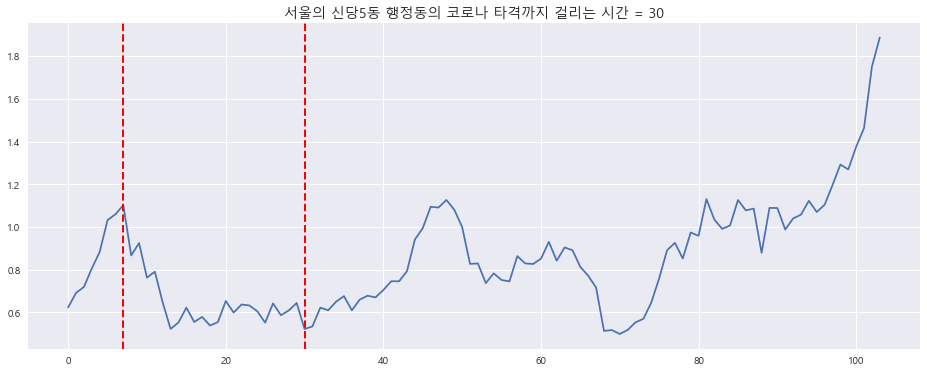

서울의 신당5동 행정동의 Impact range = 30
코로나 터지기 전 R 평균: 0.8918713466099367, 터진 후 R 최소: 0.5222917481423544 -> Impact index = 0.41438667120810574
________________________________________________


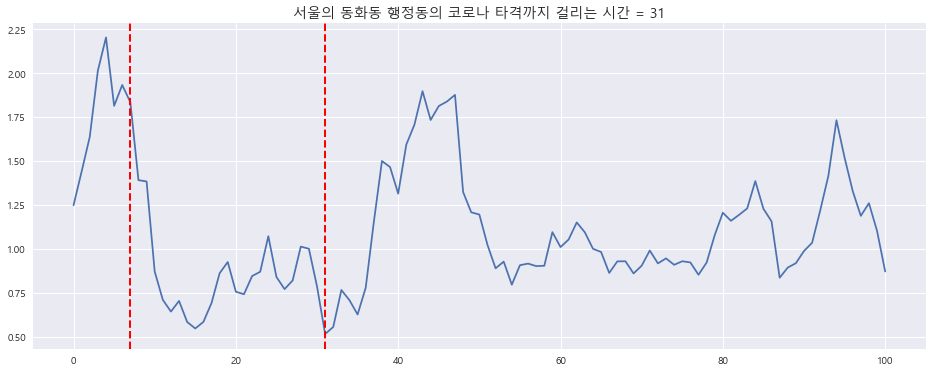

서울의 동화동 행정동의 Impact range = 31
코로나 터지기 전 R 평균: 2.5053989294590795, 터진 후 R 최소: 0.5146415348367552 -> Impact index = 0.7945869902052416
________________________________________________


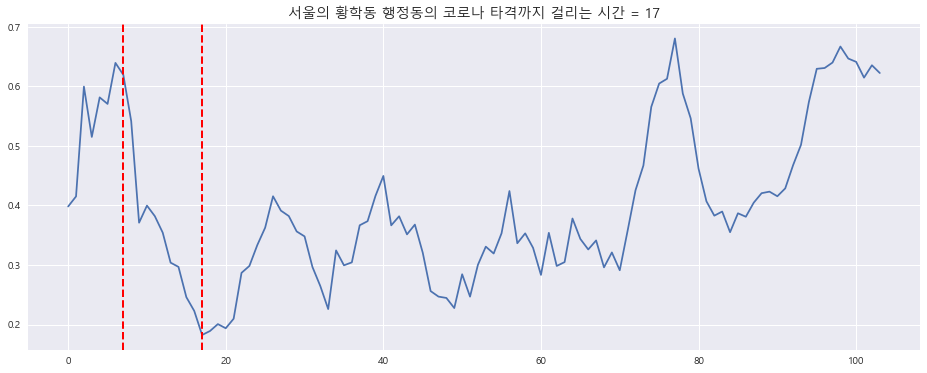

서울의 황학동 행정동의 Impact range = 17
코로나 터지기 전 R 평균: 0.6247424274109736, 터진 후 R 최소: 0.18245940910300773 -> Impact index = 0.7079445846840483
________________________________________________


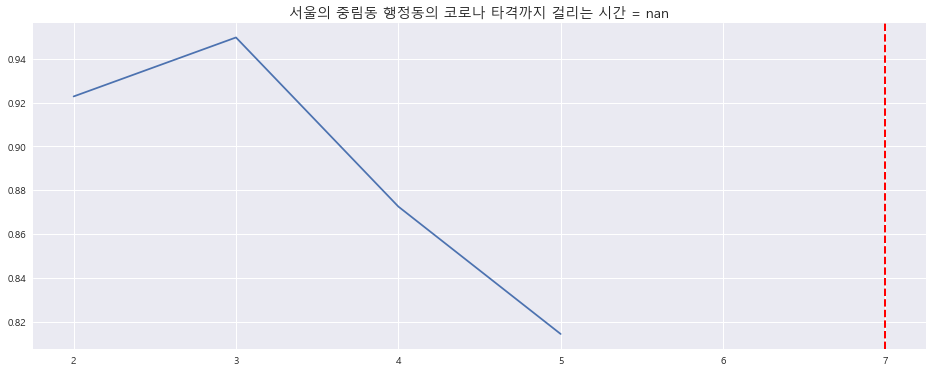

TypeError: cannot do positional indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>

In [135]:
impact_index_region_dict = impact_index_region(offline, Region = '서울',region_col = 'DONG_CD',field ='의복', val='USE_CNT')


#  도시별 + 연령대 비교

In [54]:
Fashion = offline.loc[((offline['MCT_CAT_CD']== '의복') | (offline['MCT_CAT_CD']== '신변잡화')), : ]
Fashion['Region'] = Fashion['GU_CD'].str[0:2]

In [55]:
Fashion.tail()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,AVG_AMT,YEAR,MONTH,DAY,YEAR_MONTH,WEEKDAY,WEEK_NUM,Region
2537682,2020-05-31,서울 노원구,상계10동,신변잡화,F,25,5,94,18.800000,2020,5,31,202005,6_일,22,서울
2537683,2020-05-31,서울 노원구,상계10동,신변잡화,F,55,5,51,10.200000,2020,5,31,202005,6_일,22,서울
2537684,2020-05-31,서울 노원구,상계10동,신변잡화,M,45,14,185,13.214286,2020,5,31,202005,6_일,22,서울
2537685,2020-05-31,서울 노원구,상계10동,신변잡화,M,50,5,225,45.000000,2020,5,31,202005,6_일,22,서울
2537686,2020-05-31,서울 노원구,상계10동,신변잡화,M,65,9,154,17.111111,2020,5,31,202005,6_일,22,서울


In [56]:
Fashion['AGE_CD'].unique().tolist()

[20, 25, 30, 35, 40, 45, 50, 55, 65, 60]

In [ ]:
## 6주차 월 ~ 7주차 일
## 9주차 월 ~ 11주차 일요일

In [ ]:
def impact_index_region(df, Region = '서울', Gu = '서울 노원구',region_col = 'DONG_CD', val='USE_CNT'):
    impact_index_region_dict = {}
    tmp_df = df.loc[df['Region']== Region]
    tmp_df = tmp_df.loc[tmp_df['GU_CD']== Gu]
    cat_list = tmp_df[region_col].unique().tolist()
    
    for cat in cat_list:
        tmp_df = tmp_df.loc[field_df[region_col]== cat]
        tmp_2019 = tmp_df.query('YEAR==2019').reset_index(drop=True)
        tmp_2020 = tmp_df.query('YEAR==2020').reset_index(drop=True)
        tmp_2019 = tmp_2019.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
        tmp_2020 = tmp_2020.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
        
        ### 코로나 터지기 1주전 시점의 평균
        pre_2019 = tmp_2019.iloc[13:20,6].mean()
        pre_2020 = tmp_2020.iloc[11:18,6].mean()
        
        pre_R = tmp_2020.iloc[6:20,6]/tmp_2019.iloc[7:21,6]
        pre_R = pre_R.mean()
        
        ### 이동 평균선 (7일) 구하기
        tmp_2019[val] = round(tmp_2019[val].rolling(window=7, center = True).mean(),2)
        tmp_2020[val] = round(tmp_2020[val].rolling(window=7, center = True).mean(),2)
        
        ### 두 데이터프레임의 index 맞추기.
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']>6, ]
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']<22, ].reset_index(drop = True)
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']>6, ]
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']<22, ].reset_index(drop = True)
        
        ### R_i 구하기.
        r_list = tmp_2020['USE_CNT'] / tmp_2019['USE_CNT']
      
        ### 가장 낮아진 시점 구하기.
        T = np.argmin(r_list[11:35])
        
        ### Plot 그리기
        ax = r_list.plot(figsize=(16, 6))
        ax.axvline(x=T, color='r', linewidth=2, linestyle='--')
        ax.axvline(x=7, color='r', linewidth=2, linestyle='--')
        plt.title("{}의 {} 행정동의 코로나 타격까지 걸리는 시간 = {}".format(Region, cat,T), fontsize=14)
        plt.show()
        
        
        ### Impact index 계산
        post_R = r_list.iloc[T]
        impact_index = (pre_R - post_R) / pre_R
        print("{}의 {} 행정동의 Impact range = {}".format(Region, cat, T))
        print("코로나 터지기 전 R 평균: {}, 터진 후 R 최소: {} -> Impact index = {}".format(pre_R, post_R, impact_index))
        print("________________________________________________")
   
        impact_index_region_dict[cat] = impact_index

    return  impact_index_region_dict

In [50]:
((offline['MCT_CAT_CD']== '의복') | (offline['MCT_CAT_CD']== '신변잡화'))

0          False
1          False
2          False
3          False
4          False
           ...  
2537748    False
2537749    False
2537750    False
2537751    False
2537752    False
Name: MCT_CAT_CD, Length: 2537753, dtype: bool

# ______

In [132]:
r_list = tmp_2020['USE_CNT'] / tmp_2019['USE_CNT']
r_list

0      1.207715
1      1.512633
2      1.137349
3      0.974390
4      0.980797
         ...   
107    1.005514
108    1.023254
109    0.984172
110    0.945666
111    0.907830
Name: USE_CNT, Length: 112, dtype: float64

In [150]:
offline.loc[offline['MCT_CAT_CD'] == '숙박']

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,AVG_AMT,YEAR,MONTH,DAY,YEAR_MONTH,WEEKDAY,WEEK_NUM,Region
0,2019-02-01,대구 중구,동인동,숙박,F,25,11,595,54.090909,2019,2,1,201902,4_금,5,대구
1,2019-02-01,대구 중구,동인동,숙박,F,50,5,243,48.600000,2019,2,1,201902,4_금,5,대구
2,2019-02-01,대구 중구,동인동,숙박,F,55,5,27,5.400000,2019,2,1,201902,4_금,5,대구
3,2019-02-01,대구 중구,동인동,숙박,M,20,11,243,22.090909,2019,2,1,201902,4_금,5,대구
4,2019-02-01,대구 중구,동인동,숙박,M,25,11,433,39.363636,2019,2,1,201902,4_금,5,대구
5,2019-02-01,대구 중구,동인동,숙박,M,30,11,460,41.818182,2019,2,1,201902,4_금,5,대구
135,2019-02-01,대구 중구,삼덕동,숙박,F,20,5,325,65.000000,2019,2,1,201902,4_금,5,대구
136,2019-02-01,대구 중구,삼덕동,숙박,F,25,5,325,65.000000,2019,2,1,201902,4_금,5,대구
137,2019-02-01,대구 중구,삼덕동,숙박,F,55,5,189,37.800000,2019,2,1,201902,4_금,5,대구
138,2019-02-01,대구 중구,삼덕동,숙박,M,20,5,325,65.000000,2019,2,1,201902,4_금,5,대구
